In [303]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.gen_functions import *
from src.features.map_dataset import MapDataset
from src.visualization.mapper import *
from src.models.train_model import do_rf_search
from src.visualization.vis_model import *

from shapely.geometry import Polygon, MultiPoint, Point, MultiPolygon
from scipy.stats import poisson, gamma, nbinom
plt.rcParams.update({'font.size': 16})

import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [280]:
mdataset = MapDataset('Thailand')
mdataset.load_()
mdataset.build_station_info()

build stations information for Thailand


In [38]:
mdataset.build_poll_prov(pollutant='PM2.5')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [36:14<00:00, 28.24s/it]


# Data For Modeling (in-patient data)

- Yearly average PM2.5 pollution level by province. Fill the value of the missing province with the near by provinces.
- Gender 
- Literacy rate : educated people tend to avoid going outside during the pollution season
- Average income (scaled by the average of the same year) 
- Smoking rate : for lung-related illness 
- Population ratio breakdown by ages (need to put together the data first)


In [298]:
mdataset = MapDataset('Thailand')
mdataset.load_()

# build or load pollution by province and add as .poll attribute
mdataset.load_poll_prov(pollutant='PM2.5')

# calculate the yearly average only during the winter season
#poll attributes 
poll = mdataset.poll
poll = add_season(poll, start_month='-10-01', end_month='-05-15')
# keep only winter season 
poll = poll[poll['season'] != 'other']

#poll['year'] =  poll.index.year
  
# keep year later than 2011
poll = poll.loc['2011':'2020']

# clean Buri Ram data
poll.loc[:'2020-09-01','Buri Ram'] = np.nan
poll.loc[poll[poll['Lampang'] > 250].index, 'Lampang'] = np.nan
poll.loc[poll[poll['Khon Kaen'] > 250].index, 'Khon Kaen'] = np.nan
poll.loc[poll[poll['Nong Khai'] > 250].index, 'Nong Khai'] = np.nan
poll.loc[poll[poll['Nong Bua Lam Phu'] > 250].index, 'Nong Bua Lam Phu'] = np.nan

poll.loc[:'2020-07', 'Roi Et'] = np.nan

In [299]:
mean_poll = poll.groupby('year').mean().round()

# find missing province 
missing_prov = [ s for s in mdataset.prov_map['province']  if s not in mean_poll.columns]
mean_poll = pd.concat([mean_poll, pd.DataFrame(columns=missing_prov)], axis=1)
print(mean_poll.columns.shape)

(77,)


In [300]:
near_income_list = ['Tak',
 'Narathiwat',
 'Nan',
 'Surin',
 'Sakon Nakhon',
 'Nong Bua Lam Phu',
 'Roi Et',
 'Amnat Charoen',
 'Chaiyaphum',
 'Chiang Mai',
 'Pattani',
 'Uthai Thani',
 'Loei',
 'Phrae',
 'Phetchabun',
 'Mukdahan',
 'Nong Khai',
 'Yala',
 'Uttaradit',
 'Suphan Buri']

In [301]:
interpo_dict = {
'Amnat Charoen': ['Ubon Ratchathani', 'Yasothon',  'Mukdahan'],
 'Ang Thong':["Sing Buri", "Lop Buri", "Phra Nakhon Si Ayutthaya",  "Suphan Buri"],
 'Bueng Kan': ["Nakhon Phanom", "Sakon Nakhon", "Nong Khai"],
 'Buri Ram': ['Nakhon Ratchasima', 'Khon Kaen', 'Maha Sarakham',  'Surin'], 
 'Chachoengsao': ["Prachin Buri", "Sa Kaeo", "Chanthaburi", "Chon Buri", "Samut Prakan", "Bangkok", "Pathum Thani",  "Nakhon Nayok"],
 'Chai Nat':[ "Nakhon Sawan", "Sing Buri", "Suphan Buri",   "Uthai Thani"],
 'Chiang Rai':["Phayao", "Lampang",  "Chiang Mai"],
'Chaiyaphum': ['Khon Kaen', 'Nakhon Ratchasima', 'Lop Buri', 'Phetchabun'],
'Chanthaburi': ['Trat', 'Rayong', 'Chon Buri', 'Chachoengsao', 'Sa Kaeo'],
'Chumphon': ['Prachuap Khiri Khan', 'Surat Thani',  'Ranong'],
'Kalasin': ["Sakon Nakhon", "Mukdahan",  "Maha Sarakham", "Khon Kaen", "Udon Thani"],
'Kamphaeng Phet': ["Sukhothai", "Phitsanulok", "Phichit", "Nakhon Sawan"],
 'Lampang':["Chiang Mai", "Chiang Rai", "Phayao", "Tak", "Phrae", "Sukhothai", "Lamphun"],
 'Lamphun':["Chiang Mai", "Lampang",  "Tak"],
'Lop Buri': ["Phetchabun", "Chaiyaphum", "Nakhon Ratchasima", "Saraburi", "Phranakhon Si Phra Nakhon Si Ayutthaya", "Ang Thong", "Sing Buri"],
 'Mae Hong Son':[ "Chiang Mai", "Tak"],
 'Maha Sarakham': ["Kalasin", "Roi Et", "Surin", "Buri Ram", "Khon Kaen"],
 'Mukdahan': [ "Amnat Charoen", "Yasothon", "Roi Et", "Kalasin", "Sakon Nakhon", "Nakhon Phanom"],
 'Nakhon Nayok':[ "Saraburi", "Nakhon Ratchasima", "Prachin Buri", "Chachoengsao",  "Pathum Thani"],
 'Nakhon Pathom':[ "Suphan Buri", "Phra Nakhon Si Ayutthaya", "Nonthaburi", "Bangkok", "Samut Sakhon", "Ratchaburi", "Kanchanaburi"],
 'Nakhon Phanom':["Mukdahan", "Sakon Nakhon",  "Bueng Kan"],
 'Nakhon Ratchasima':["Chaiyaphum", "Khon Kaen", "Buri Ram", "Sa Kaeo", "Prachin Buri", "Nakhon Nayok", "Saraburi", "Lop Buri"],
 'Nakhon Sawan':["Kamphaeng Phet", "Phichit", "Phetchabun", "Lop Buri", "Sing Buri", "Chai Nat", "Uthai Thani", "Tak"],
 'Nakhon Si Thammarat': ["Songkhla", "Phatthalung", "Trang", "Krabi", "Surat Thani"] ,
 'Narathiwat':["Yala", "Pattani"],
 'Nong Bua Lam Phu': [ "Udon Thani", "Khon Kaen",  "Loei"],
 'Nong Khai':["Bueng Kan", "Sakon Nakhon", "Udon Thani", "Loei"],
 'Pathum Thani':["Phra Nakhon Si Ayutthaya", "Saraburi", "Nakhon Nayok", "Chachoengsao", "Bangkok", "Nonthaburi"],
 'Phayao':[ "Nan", "Phrae", "Lampang",   "Chiang Rai"],
 'Phetchaburi':[ "Ratchaburi", "Samut Songkhram", "Prachuap Khiri Khan"],
    'Phetchabun': ["Loei", "Khon Kaen", "Chaiyaphum", "Lop Buri", "Nakhon Sawan", "Phichit", "Phitsanulok"],
'Phichit': [ "Phitsanulok", "Nakhon Sawan",  "Kamphaeng Phet"],
 'Phrae': ["Phayao", "Nan", "Uttaradit", "Sukhothai",  "Lampang"],
 'Prachuap Khiri Khan': ["Phetchaburi", "Chumphon"],
  'Roi Et': ["Mukdahan", "Yasothon", "Si Sa Ket", "Surin", "Maha Sarakham"],
 'Sakon Nakhon':["Nong Khai", "Bueng Kan", "Nakhon Phanom", "Mukdahan", "Kalasin",   "Udon Thani"],
 'Samut Songkhram': [ "Phetchaburi", "Ratchaburi", "Samut Sakhon"],
 'Satun':["Trang", "Phatthalung",  "Songkhla"],
 'Si Sa Ket': ["Surin", "Roi Et", "Yasothon",  "Ubon Ratchathani"],
 'Sukhothai':[ "Phrae", "Uttaradit", "Phitsanulok", "Kamphaeng Phet", "Tak",   "Lampang"],
'Trang': ["Krabi", "Nakhon Si Thammarat", "Phatthalung",  "Satun"],
 'Trat':['Chanthaburi'],
 'Ubon Ratchathani': ['Si Sa Ket', "Yasothon",  "Amnat Charoen"],
'Udon Thani': ["Nong Khai",  'Khon Kaen',  'Loei', 'Nong Bua Lamphu'],
'Uthai Thani': ['Nakhon Sawan', 'Chai Nat', 'Suphan Buri', 'Kanchanaburi',  'Tak'],
'Uttaradit': [ 'Phitsanulok', 'Sukhothai', 'Phrae' , 'Nan'],
 'Yala':[ "Songkhla", "Pattani", "Narathiwat"],
 'Yasothon': ["Mukdahan", "Amnat Charoen", "Ubon Ratchathani", "Si Sa Ket",  "Roi Et"],
"Krabi": ["Phangnga", "Surat Thani", "Nakhon Si Thammarat",   "Trang"],
"Pattani": ["Narathiwat", "Yala",  "Songkhla"],
"Phangnga":["Ranong", "Surat Thani",   "Krabi"],
"Phatthalung":["Nakhon Si Thammarat", "Songkhla", "Satun",   "Trang"],
"Ranong":[ "Chumphon", "Surat Thani",   "Phangnga"],
"Sing Buri":[ "Nakhon Sawan", "Lop Buri", "Ang Thong", "Suphan Buri",   "Chai Nat"],
"Surin":[ "Buri Ram", "Maha Sarakham", "Roi Et",   "Si Sa Ket"],
"Suphan Buri": [ "Uthai Thani", "Chai Nat", "Sing Buri", "Ang Thong", "Phra Nakhon Si Ayutthaya", "Nakhon Pathom", "Kanchanaburi"], 
    "Phra Nakhon Si Ayutthaya": ["Ang Thong", "Lop Buri", "Saraburi", "Pathum Thani", "Nonthaburi", "Nakhon Pathom", "Suphan Buri"],
"Loei": [ "Nong Khai", "Udon Thani", "Nong Bua Lam Phu", "Khon Kaen", "Phetchabun", "Phitsanulok"],
    "Sa Kaeo":["Chanthaburi", "Chachoengsao", "Prachin Buri", "Nakhon Ratchasima",  "Buri Ram"] 
}

In [302]:
missing_city_list = mean_poll.count()[mean_poll.count() < 5].index.to_list()
missing_city_list

['Amnat Charoen',
 'Ang Thong',
 'Bueng Kan',
 'Buri Ram',
 'Chachoengsao',
 'Chai Nat',
 'Lamphun',
 'Mae Hong Son',
 'Mukdahan',
 'Nakhon Nayok',
 'Nakhon Phanom',
 'Narathiwat',
 'Nong Bua Lam Phu',
 'Phayao',
 'Phetchaburi',
 'Phichit',
 'Phrae',
 'Prachuap Khiri Khan',
 'Roi Et',
 'Samut Songkhram',
 'Satun',
 'Si Sa Ket',
 'Sukhothai',
 'Trat',
 'Ubon Ratchathani',
 'Uthai Thani',
 'Yasothon',
 'Krabi',
 'Pattani',
 'Phangnga',
 'Phatthalung',
 'Ranong',
 'Sing Buri',
 'Surin']

In [293]:
for city in missing_city_list:
    if city in interpo_dict.keys():
        fill_df = mean_poll[interpo_dict[city]].mean(axis=1).round()
        mean_poll[city] = mean_poll[city].fillna(fill_df)
        
    else:
        print(city)

In [294]:
avg_pm24_prov = mean_poll.melt(value_name = 'avgPM2.5', var_name='province', ignore_index=False) 
avg_pm24_prov.index.name = "year"
avg_pm24_prov = avg_pm24_prov.reset_index()

In [295]:
year_prov = avg_pm24_prov[['year', 'province']]
avg_pm24_prov_noyear = avg_pm24_prov.groupby('province').mean().round(2)
avg_pm24_prov_noyear = avg_pm24_prov_noyear.drop('year', axis=1)
# remove small stat province
avg_pm24_prov_noyear.loc[missing_city_list] = np.nan

# fill missing value 
for city in missing_city_list:
    if city in interpo_dict.keys():
        fill_df = avg_pm24_prov_noyear.loc[interpo_dict[city]].mean().round(2)
        avg_pm24_prov_noyear.loc[city] = avg_pm24_prov_noyear.loc[city].fillna(fill_df)
        
    else:
        print(city)
        
add_list = avg_pm24_prov_noyear[avg_pm24_prov_noyear.isna().values.flatten()].index.to_list()
 
# fill missing value 
for city in add_list:
    if city in interpo_dict.keys():
        fill_df = avg_pm24_prov_noyear.loc[interpo_dict[city]].mean().round(2)
        avg_pm24_prov_noyear.loc[city] = avg_pm24_prov_noyear.loc[city].fillna(fill_df)
        
    else:
        print(city)
        
# add year 

avg_pm24_prov_noyear = year_prov.merge(avg_pm24_prov_noyear, left_on='province', right_index=True, how='right')

Select disease to study and load the data

In [325]:
dis = 'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด'
#dis = 'Conduction disorders and cardiac arrhythmias (I44-I49)\nความผิดปกติของการนำกระแสไฟฟ้าหัวใจและหัวใจเต้นผิดจังหวะ'

population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
in_pat = pd.read_csv(mdataset.health_folder + 'process/in_patient_2007_2019.csv').dropna()
in_pat['year'] = in_pat['year'].astype(int)
# in_pat = in_pat[~in_pat['year'].isin([2013, 2016])]
# add population 
in_pat = in_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate
birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

in_pat = in_pat.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
in_pat = in_pat.merge(provinces, on='province', how='left')

# remove use number and remove total in gender 
in_pat = in_pat[(in_pat['number_type'] == 'number') & (in_pat['gender'].isin(['Male', 'Female'])) ]
in_pat = in_pat[~in_pat['region'].isna()]

in_pat = in_pat[in_pat['disease'] == dis]

in_pat['rate'] = (in_pat['number']/in_pat['pop']*1000).round(2)

in_pat['birth_rate'] = (in_pat['birth_number']/in_pat['pop']*1000).round()

- Literacy rate : educated people tend to avoid going outside during the pollution season-

- Average income (scaled by the average of the same year)

- Smoking rate : for lung-related illness

- Population ratio breakdown by ages (need to put together the data first)

- population size (normalized by average province size)

In [11]:
def load_lit_rate():
    lit_rate = pd.read_csv(mdataset.health_folder  + 'process/18_literacy_2008.csv')
    lit_rate = lit_rate.rename(columns={'rate':'lit_rate'})
    return lit_rate.drop_duplicates()

In [12]:
def load_smoke():
    smoke = pd.read_csv(mdataset.health_folder  + 'process/smoke.csv')
    smoke['year'] = smoke['year'].astype(int)

    # remove strange year 
    smoke = smoke[~smoke['year'].isin([2001, 2014])]
    smoke = smoke.set_index(['region', 'gender', 'year'])

    # calculate the rate 
    smoke['total'] = smoke.sum(axis=1)
    smoke['smoke_rate'] = smoke['frequent']/smoke['total']

    smoke = smoke[['smoke_rate']].reset_index()

    # separate into male and female
    smoke_male = smoke[smoke['gender'] == 'Male']

    smoke_female = smoke[smoke['gender'] == 'Female']
    # remove data after year 2012 for female 
    smoke_female = smoke_female[smoke_female['year'] < 2012]

    # fill missing value 

    temp_male = []
    for region in smoke_male['region'].unique():
    
        df = smoke_male[smoke_male['region'] == region]
        df = df.set_index('year')
        missing_year = [y for y in np.arange(2000, 2021) if y not in df.index]
        df = pd.concat([df, pd.DataFrame(index=missing_year)])
        df = df.sort_index()
        df = df.fillna(method='ffill')
        df = df.fillna(df.mean())
        df = df.fillna(method='bfill')
        
        df['smoke_rate'] = df['smoke_rate'].round(2)
        df.index.name = 'year'
        temp_male.append(df.reset_index())
    
    temp_male = pd.concat(temp_male)

    temp_female = []
    for region in smoke_female['region'].unique():
    
        df = smoke_female[smoke_female['region'] == region]
        df = df.set_index('year')
        missing_year = [y for y in np.arange(2000, 2021) if y not in df.index]
        df = pd.concat([df, pd.DataFrame(index=missing_year)])
        df = df.sort_index()
        df = df.fillna(method='ffill')
        df = df.fillna(df.mean())
        df = df.fillna(method='bfill')
        
        df['smoke_rate'] = df['smoke_rate'].round(2)
        df.index.name = 'year'
        temp_female.append(df.reset_index())
    
    temp_female = pd.concat(temp_female)

    smoke_rate = pd.concat([temp_male, temp_female])
    
    
    return smoke_rate.drop_duplicates()

In [13]:
def load_income():
    income = pd.read_csv(mdataset.health_folder  + 'process/income_98_19.csv')
    income = income.drop('thaiprov', axis=1)

    #remove region
    income = income[~income['province'].isin(['Whole Kingdom', 'Greater Bangkok', 'Northeastern Region', 'Northern Region',  'Central Region', 'Southern Region'])]


    income = income.set_index('province')

    income_avg = income.mean(axis=0) 

    # normalized by national avg 

    for year in income.columns:
        income[year] /= income_avg[year]
        income[year] = income[year].round(2)
    
    add_col = [ s for s in np.arange(2000, 2021).astype(str) if s not in income.columns]

    for col in add_col:
        income[col] = np.nan
  
    # reorder columns
    income = income.reindex(sorted(income.columns), axis=1)

    # Fill missing year
    income = income.fillna(method = 'ffill', axis=1)
    
    income = income.melt(ignore_index=False, value_name = 'income', var_name='year').reset_index()

    income['year'] = income['year'].astype(int)
    return income.drop_duplicates()

In [14]:
def load_pop_avg():
    pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
    pop['year'] = pop['year'].astype(int)

    pop_mean = pop.groupby(['year', 'gender'], as_index=False).mean()
    pop_mean = pop_mean.rename(columns={'pop': 'avg_pop'})
    pop_sum = pop.groupby(['year', 'gender'], as_index=False).sum()
    pop_sum = pop_sum.rename(columns={'pop': 'sum_pop'})

    pop_avg = pop.merge(pop_mean, on = ['year', 'gender'], how='left')
    pop_avg = pop_avg.merge(pop_sum, on = ['year', 'gender'], how='left' )

    pop_avg['pop_per_avg'] = (pop_avg['pop']/pop_avg['avg_pop']).round(2)
    pop_avg['pop_per_sum'] = (pop_avg['pop']/pop_avg['sum_pop']*100).round(2)

    pop_avg = pop_avg[['province', 'gender', 'year', 'pop_per_avg', 'pop_per_sum']]
    
    pop_avg['year'] = pop_avg['year'].astype(int)
    return pop_avg.drop_duplicates()

In [15]:
def load_pop_ratio():
    
    pop_ratio = pd.read_csv(mdataset.health_folder  + 'process/pop_per_age_group_no_infant.csv')
    
    pop_ratio['year'] = pop_ratio['year'].astype(int)
    return pop_ratio.drop_duplicates()

In [16]:
def build_data(illness_data, poll_data):
    
    data = illness_data[['gender', 'province', 'year', 'pop', 'birth_number', 'region', 'rate', 'birth_rate']].drop_duplicates()
    
    
    # merge with pollution 
    data = data.merge(poll_data.dropna(), on=['year', 'province'], how='inner')
    
    # merge with income
    income = load_income()
    data = data.merge(income.dropna(), on=['year', 'province'], how='inner')
    
    # merge with pop_ratio
    pop_ratio = load_pop_ratio()
    data = data.merge(pop_ratio.dropna(), on=['year', 'province', 'gender'], how='inner')
    
    # merge with province pop size
    pop_avg = load_pop_avg()
    data = data.merge(pop_avg.dropna(), on=['year', 'province', 'gender'], how='inner')
    
    # merge with smoke_rate
    smoke_rate = load_smoke()
    data = data.merge(smoke_rate.dropna(), on=['year', 'region', 'gender'], how='inner')
    
    # merge with literacy rate
    lit_rate = load_lit_rate()
    data = data.merge(lit_rate.dropna(), on=['region'], how='inner')
    
    
    print('data shape', data.shape)
    return data.drop_duplicates()

In [326]:
data = build_data(in_pat, avg_pm24_prov)
data_noyear = build_data(in_pat, avg_pm24_prov_noyear)
data.head()

data shape (846, 26)
data shape (1350, 26)


gender province  year        pop  birth_number           region  rate  \
0    Male  Bangkok  2011  2692954.0       96703.0  Greater Bangkok  0.55   
1  Female  Bangkok  2011  2981889.0       96703.0  Greater Bangkok  0.64   
2    Male  Bangkok  2012  2690754.0       97581.0  Greater Bangkok  0.53   
3  Female  Bangkok  2012  2982806.0       97581.0  Greater Bangkok  0.67   
4    Male  Bangkok  2013  2694921.0       93828.0  Greater Bangkok  3.57   

   birth_rate  avgPM2.5  income  ...  40-49  50-59  60-69  70-79  80-89   90+  \
0        36.0      36.0    2.35  ...  14.36  11.37   5.82   2.91   0.82  0.14   
1        32.0      36.0    2.35  ...  15.08  12.15   6.65   3.73   1.32  0.21   
2        36.0      35.0    2.35  ...  14.32  11.64   6.15   3.04   0.90  0.15   
3        33.0      35.0    2.35  ...  15.03  12.44   7.03   3.87   1.43  0.22   
4        35.0      32.0    2.12  ...  14.22  11.83   6.51   3.16   1.01  0.16   

   pop_per_avg  pop_per_sum  smoke_rate  lit_rate  
0         2.40         2.93        0.26      0.83  
1         2.58         3.15        0.09      0.83  
2         2.39         2.91        0.26      0.83  
3         2.57         3.13        0.09      0.83  
4         2.38         2.90        0.20      0.83  

[5 rows x 26 columns]

In [97]:
data = data.to_csv(mdataset.health_folder  + 'process/in_pat_lung_data.csv', index=False)

In [43]:
# consider bangkok as central region 
data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )

data['region'] = data['region'].astype('category')

In [119]:
prov_split = data[['province', 'region' ]].drop_duplicates()

In [128]:
# split province into train-test provinces, stratify by regions
prov_trn, prov_val = train_test_split(prov_split['province'].values, test_size=0.25, stratify=prov_split['region'].cat.codes.values )

# check to provent overlap (split over)
set(prov_trn).intersection(set(prov_val))

set()

In [130]:
data.columns

Index(['gender', 'province', 'year', 'pop', 'birth_number', 'region', 'rate',
       'birth_rate', 'avgPM2.5', 'income', '40-44', '45-49', '0-9', '10-19',
       '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+',
       'pop_per_avg', 'pop_per_sum', 'smoke_rate', 'lit_rate'],
      dtype='object')

In [136]:
# encode gender columns
data['gender'] = data['gender'].astype('category')
data['Female'] = pd.get_dummies(data['gender'])['Female']

In [19]:
data.columns

Index(['gender', 'province', 'year', 'pop', 'birth_number', 'region', 'rate',
       'birth_rate', 'avgPM2.5', 'income', '40-44', '45-49', '0-9', '10-19',
       '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+',
       'pop_per_avg', 'pop_per_sum', 'smoke_rate', 'lit_rate'],
      dtype='object')

In [21]:
data.head()

gender province  year        pop  birth_number           region  rate  \
0    Male  Bangkok  2011  2692954.0       96703.0  Greater Bangkok  0.81   
1  Female  Bangkok  2011  2981889.0       96703.0  Greater Bangkok  0.45   
2    Male  Bangkok  2012  2690754.0       97581.0  Greater Bangkok  0.80   
3  Female  Bangkok  2012  2982806.0       97581.0  Greater Bangkok  0.47   
4    Male  Bangkok  2013  2694921.0       93828.0  Greater Bangkok  1.15   

   birth_rate  avgPM2.5  income  ...  40-49  50-59  60-69  70-79  80-89   90+  \
0        36.0      42.0    2.35  ...  14.36  11.37   5.82   2.91   0.82  0.14   
1        32.0      42.0    2.35  ...  15.08  12.15   6.65   3.73   1.32  0.21   
2        36.0      42.0    2.35  ...  14.32  11.64   6.15   3.04   0.90  0.15   
3        33.0      42.0    2.35  ...  15.03  12.44   7.03   3.87   1.43  0.22   
4        35.0      42.0    2.12  ...  14.22  11.83   6.51   3.16   1.01  0.16   

   pop_per_avg  pop_per_sum  smoke_rate  lit_rate  
0         2.40         2.93        0.26      0.83  
1         2.58         3.15        0.09      0.83  
2         2.39         2.91        0.26      0.83  
3         2.57         3.13        0.09      0.83  
4         2.38         2.90        0.20      0.83  

[5 rows x 26 columns]

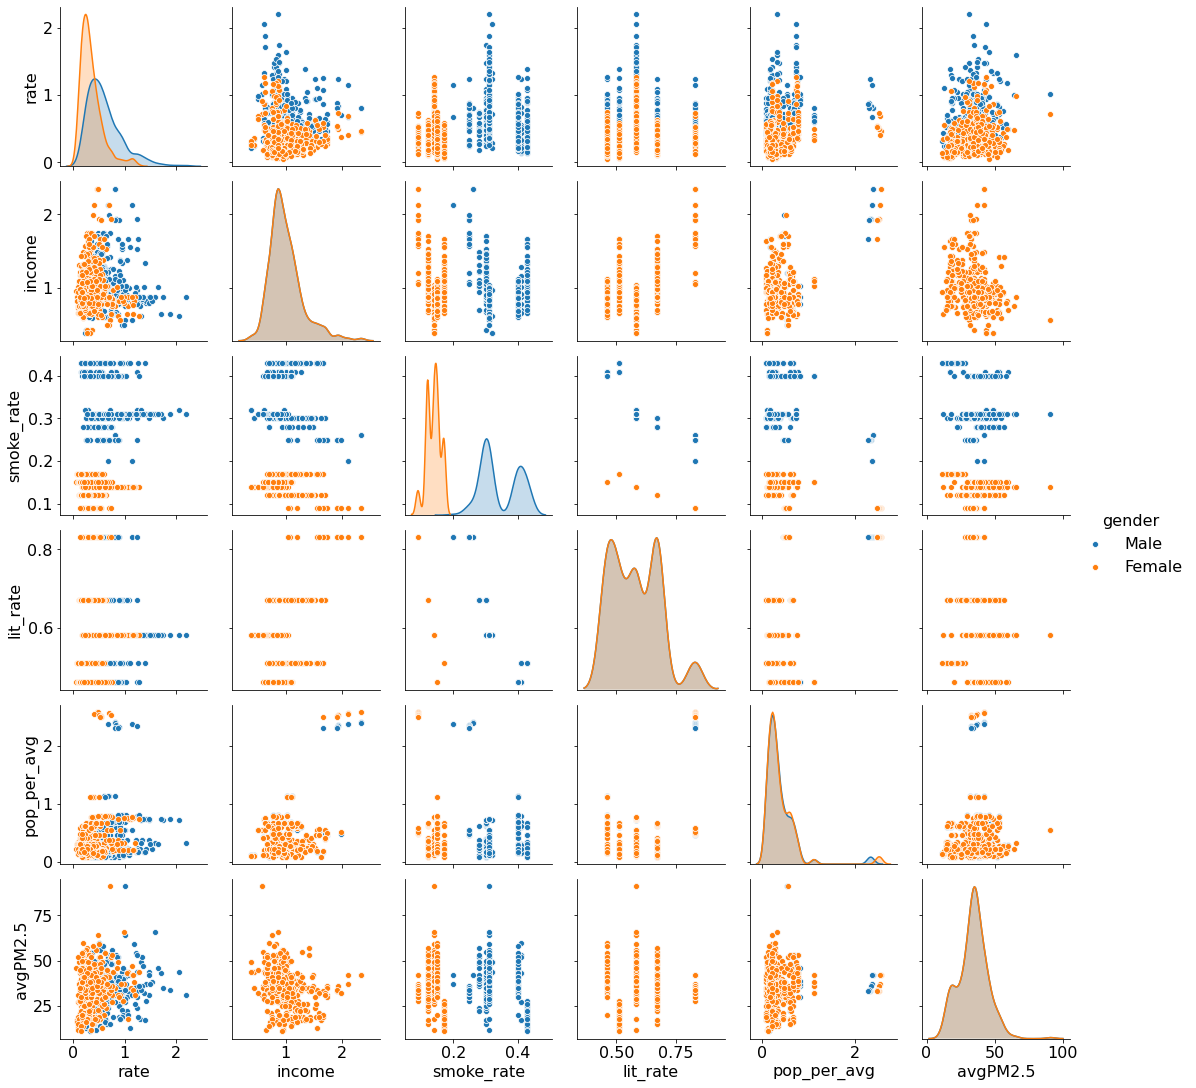

In [266]:
g = sns.pairplot(data, vars=['rate','income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5'],
                 hue='gender' )

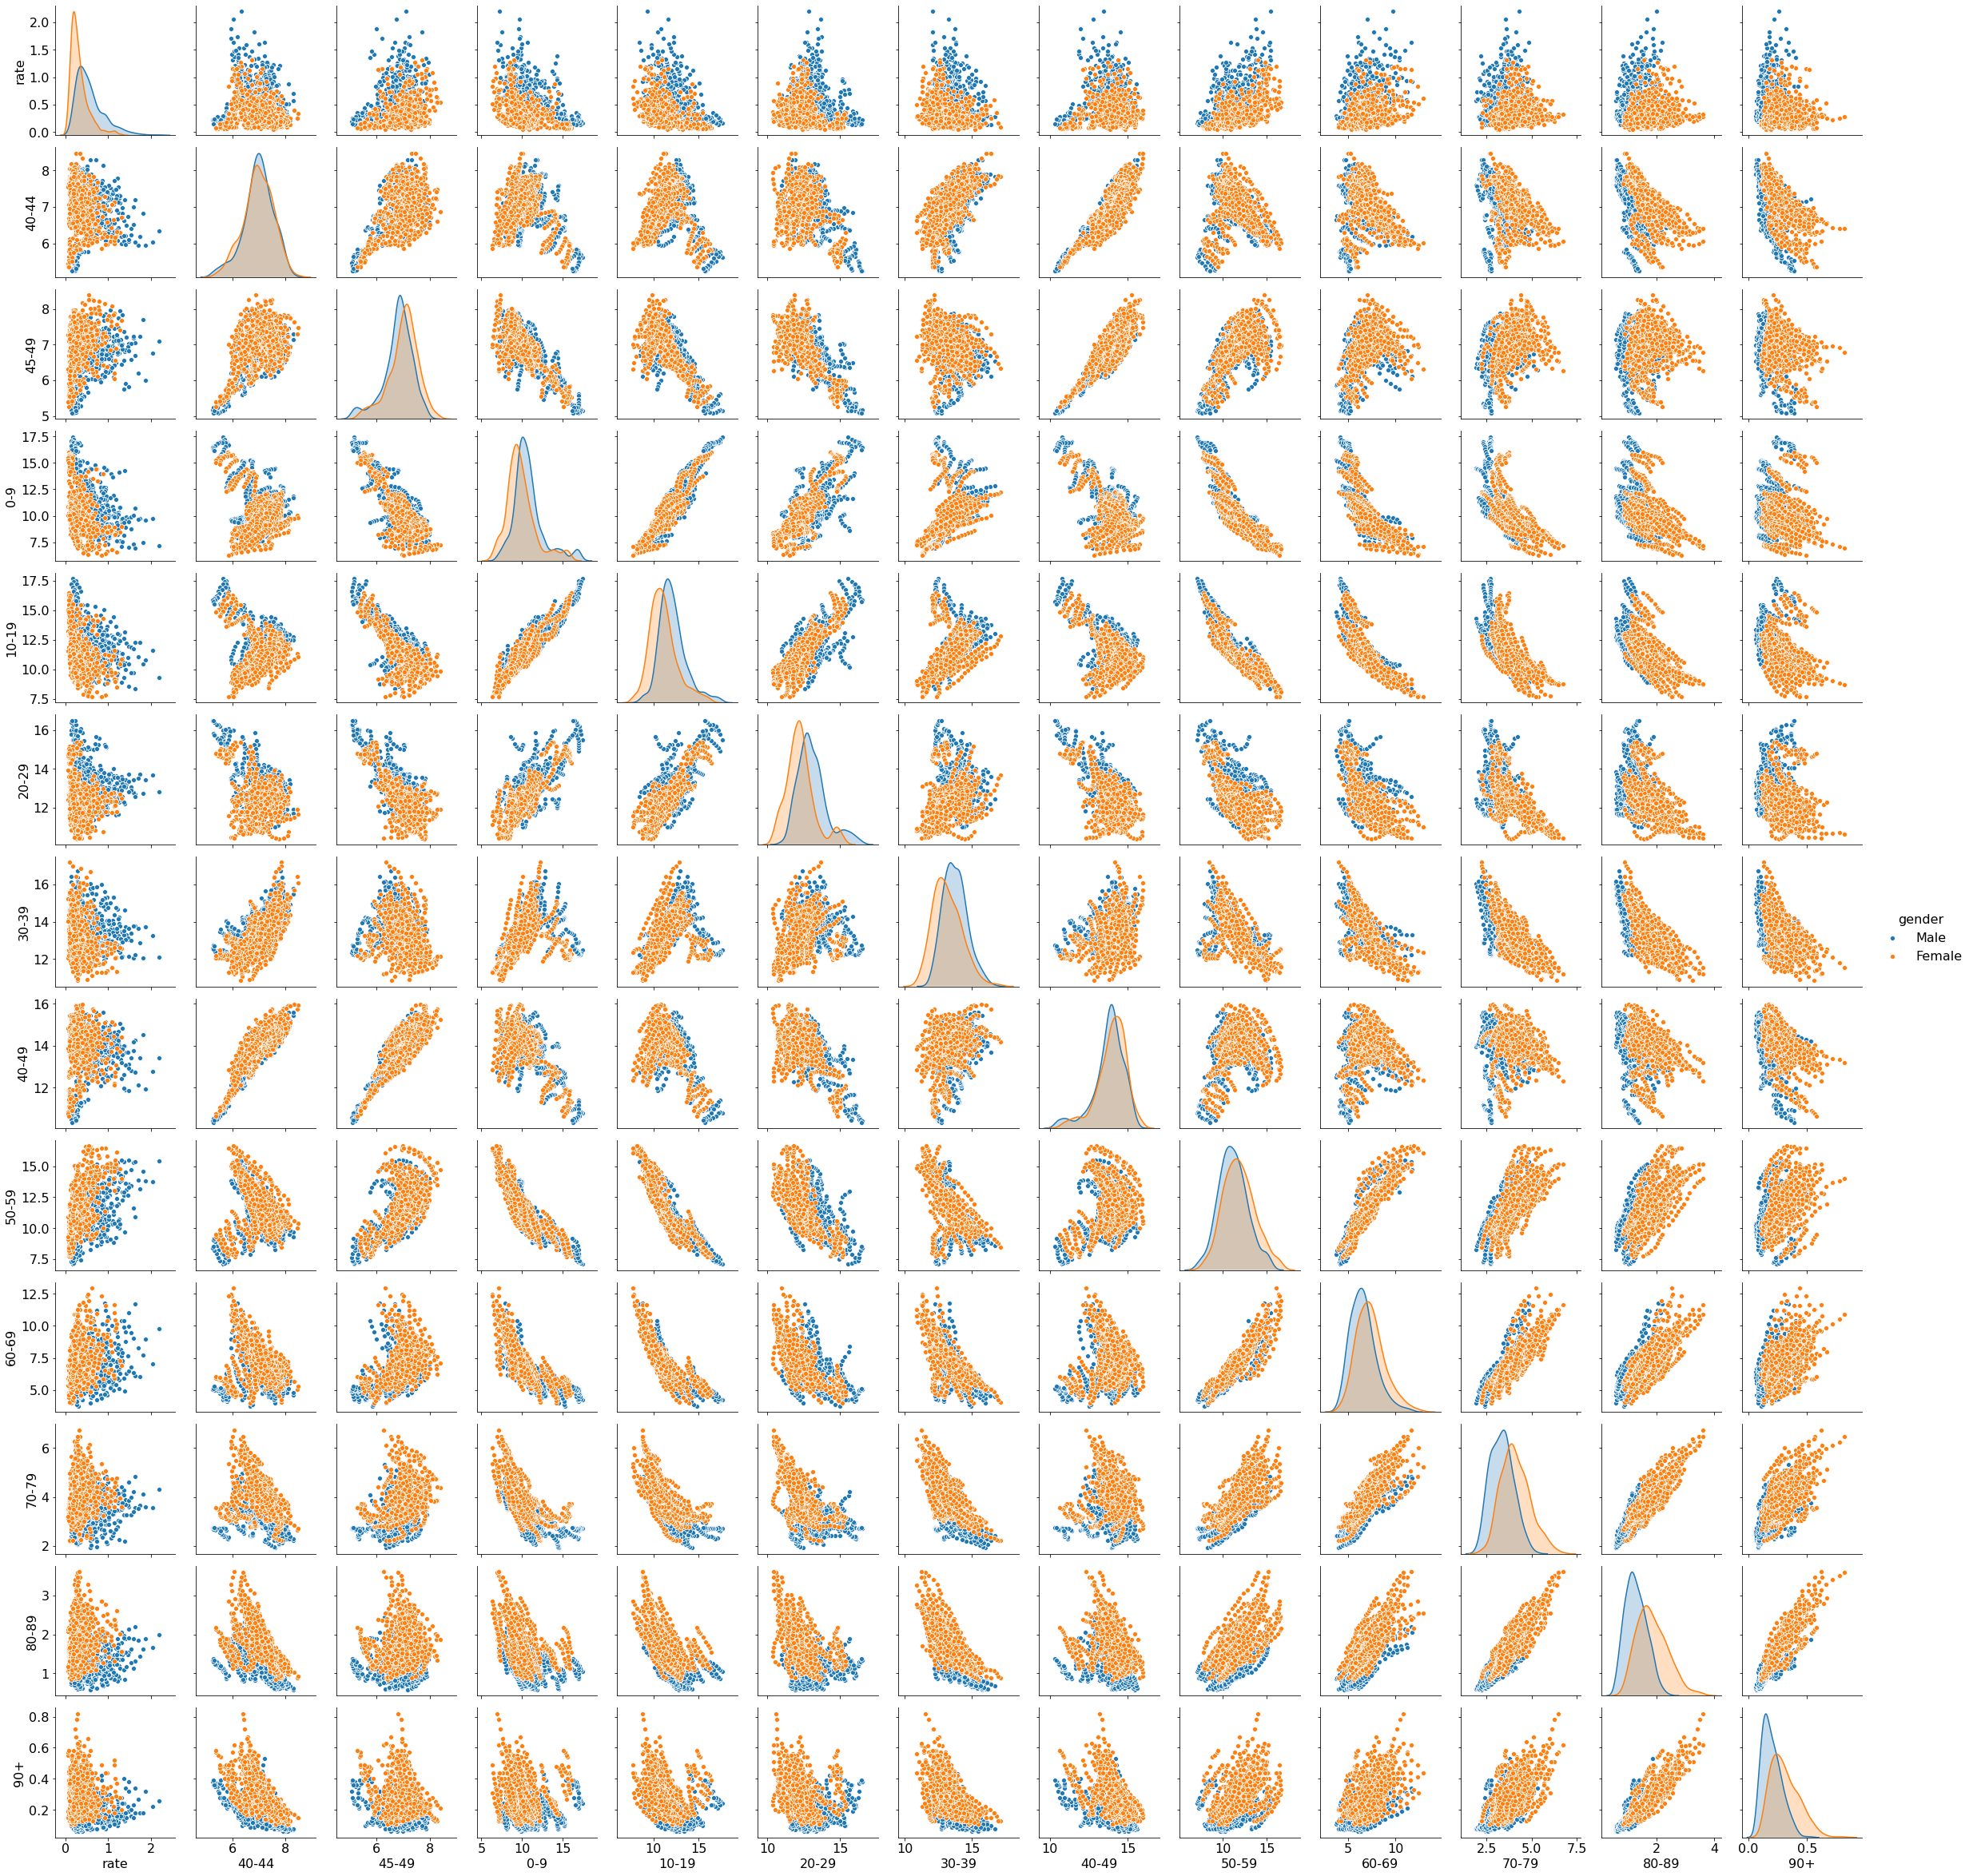

In [419]:
#g = sns.pairplot(data_noyear, vars=['rate','income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5'],
#                 hue='gender' )
    
g = sns.pairplot(data_noyear, vars=['rate', '40-44', '45-49', '0-9', '10-19',
       '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+'], hue='gender' )

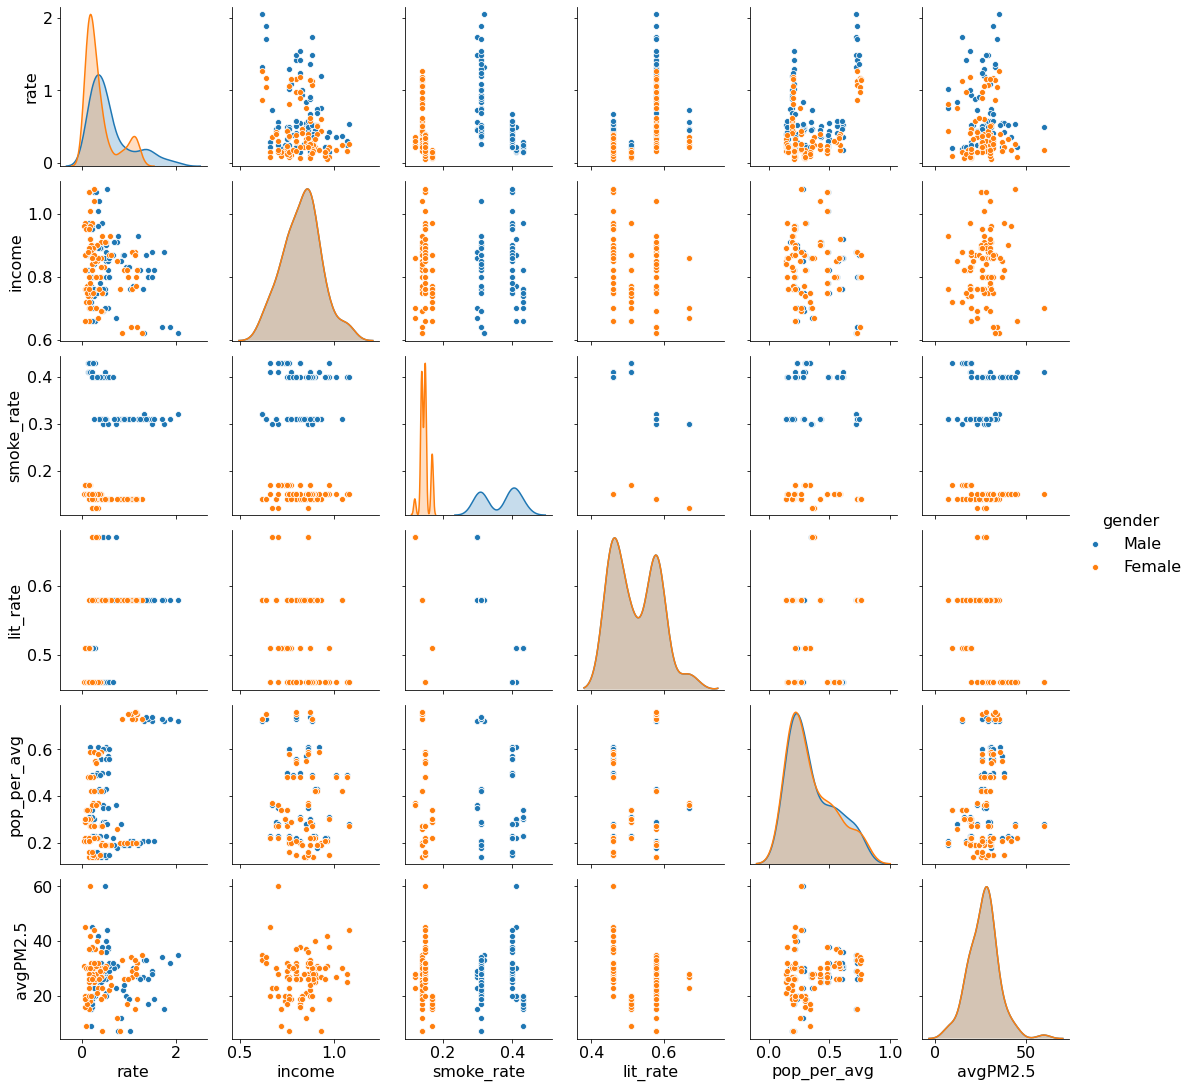

In [176]:
temp = data[data['province'].isin(near_income_list)]

g = sns.pairplot(temp, vars=['rate','income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5'],
                 hue='gender' )



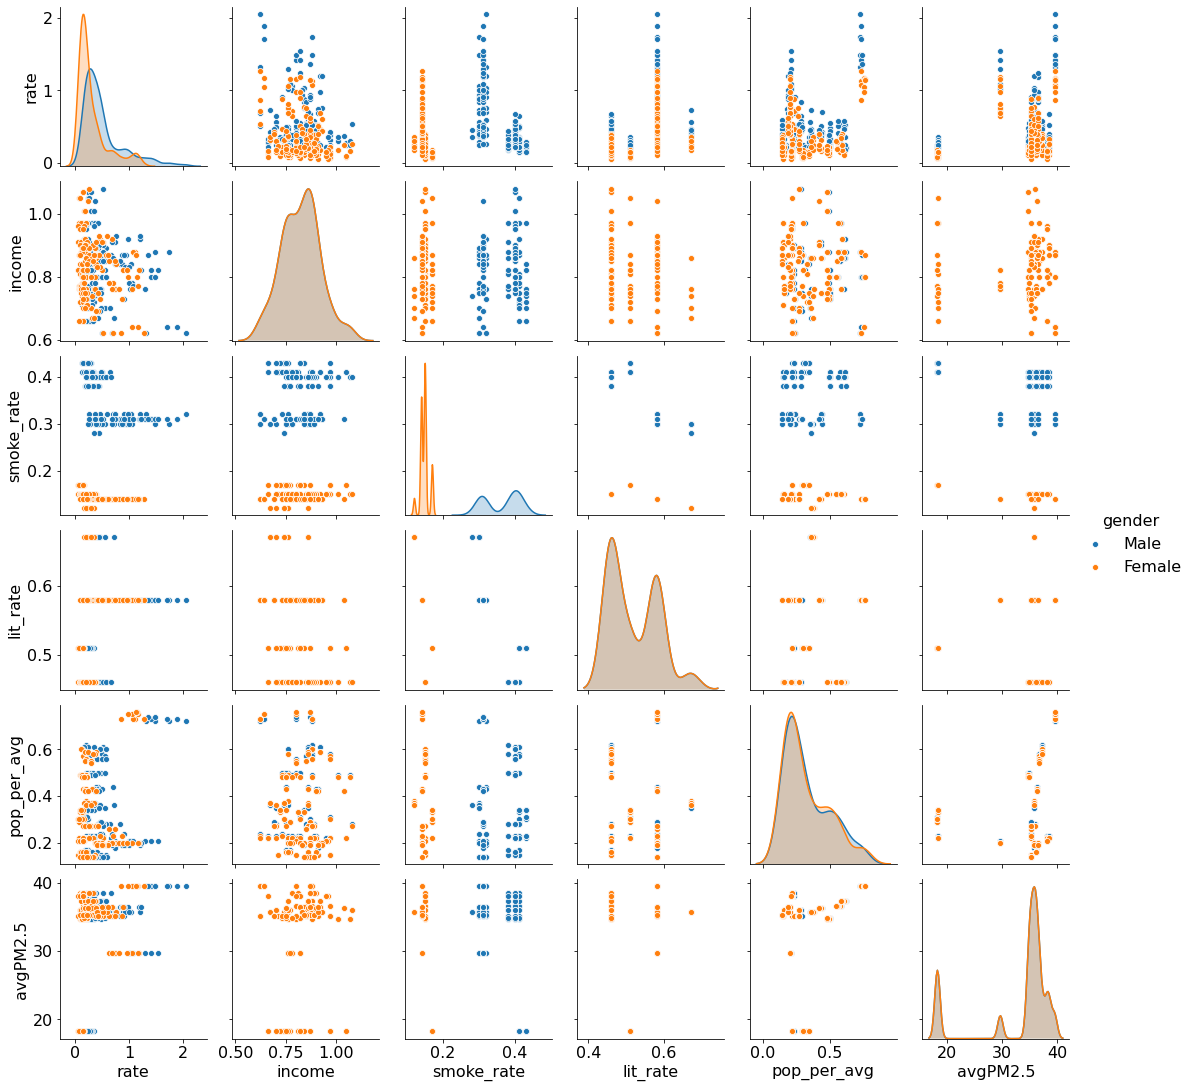

In [268]:
temp = data_noyear[data_noyear['province'].isin(near_income_list)]

g = sns.pairplot(temp, vars=['rate','income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5'],
                 hue='gender' )

## Both Gender 

In [185]:
# preparing data for training and validation
x_cols = [ 'avgPM2.5', 'income', '40-44', '45-49', '0-9', '10-19',
       '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+',
       'pop_per_avg', 'pop_per_sum', 'smoke_rate', 'lit_rate']

x_cols = [   'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
y_col = 'rate' 

#data_proc = data[data['gender'] == 'Female']

data_proc = data

x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values


x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values

In [186]:
model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

cal_scores(y_val, model.predict(x_val), header_str='val_')

best rf score  0.08404552980416675


{'val_r2_score': 0.335,
 'val_r2': 0.6695,
 'val_mean_squared_error': 0.1203,
 'val_mean_absolute_error': 0.2313,
 'val_mean_absolute_percentage_error': 39.5329,
 'val_median_absolute_error': 0.1356}

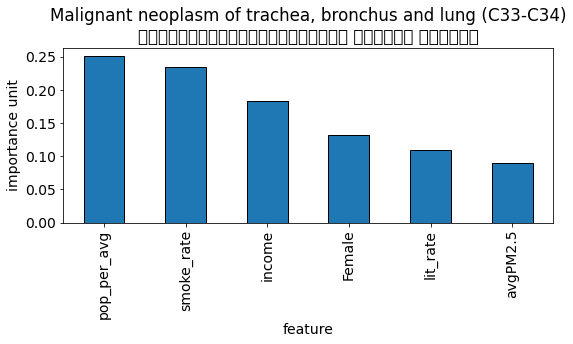

In [187]:
importances = model.feature_importances_
feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
show_fea_imp(feat_imp, title=dis, filename=mdataset.report_folder + 'feat_imp_lung_both.png')

## Female 

In [188]:
# preparing data for training and validation
x_cols = [ 'avgPM2.5', 'income', '40-44', '45-49', '0-9', '10-19',
       '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+',
       'pop_per_avg', 'pop_per_sum', 'smoke_rate', 'lit_rate']

x_cols = [   'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5']
y_col = 'rate' 

data_proc = data[data['gender'] == 'Female']

#data_proc = data

x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values


x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values

In [189]:
model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

cal_scores(y_val, model.predict(x_val), header_str='val_')

best rf score  -0.19248553989054093


{'val_r2_score': 0.2644,
 'val_r2': 0.6345,
 'val_mean_squared_error': 0.0689,
 'val_mean_absolute_error': 0.1831,
 'val_mean_absolute_percentage_error': 43.5781,
 'val_median_absolute_error': 0.1055}

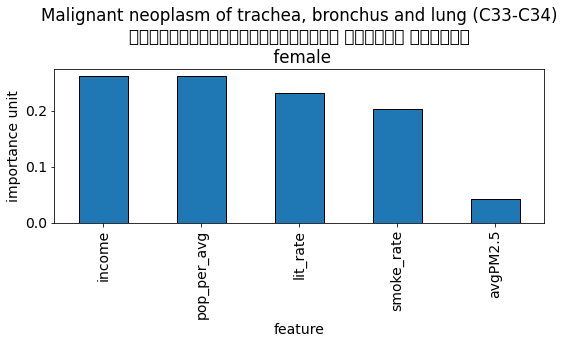

In [190]:
importances = model.feature_importances_
feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
# show_fea_imp(feat_imp, title=dis + '\n female', filename=mdataset.report_folder + 'feat_imp_lung_female.png')

## All in_patient illness

In [192]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
in_pat = pd.read_csv(mdataset.health_folder + 'process/in_patient_2007_2019.csv').dropna()
in_pat['year'] = in_pat['year'].astype(int)
# in_pat = in_pat[~in_pat['year'].isin([2013, 2016])]
# add population 
in_pat = in_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate
birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

in_pat = in_pat.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
in_pat = in_pat.merge(provinces, on='province', how='left')

# remove use number and remove total in gender 
in_pat = in_pat[(in_pat['number_type'] == 'number') & (in_pat['gender'].isin(['Male', 'Female'])) ]
in_pat = in_pat[~in_pat['region'].isna()]

data shape (664, 26)
----------Systemic connective tissue disorders (M30-M36)
ความผิดปกติของระบบเนื้อเยื่อประสาน-----------------
-------------------both gender-----------------------
best rf score  0.39798174956963916
-------------------female-----------------------
best rf score  0.16898470640318722
data shape (664, 26)
----------Malignant neoplasm of trachea, bronchus and lung (C33-C34)
เนื้องอกร้ายที่หลอดคอ หลอดลม และปอด-----------------
-------------------both gender-----------------------
best rf score  0.004232646927206744
-------------------female-----------------------
best rf score  -0.9087535102952637
data shape (664, 26)
----------Other diseases of the circulatory system (I85-I99) 
โรคอื่น ๆ ของระบบไหลเวียนโลหิต-----------------
-------------------both gender-----------------------
best rf score  -0.17726589577536278
-------------------female-----------------------
best rf score  -0.28660566492412703
data shape (664, 26)
----------Septicemia (A40-A41)
โลหิตเป็นพิษ----------

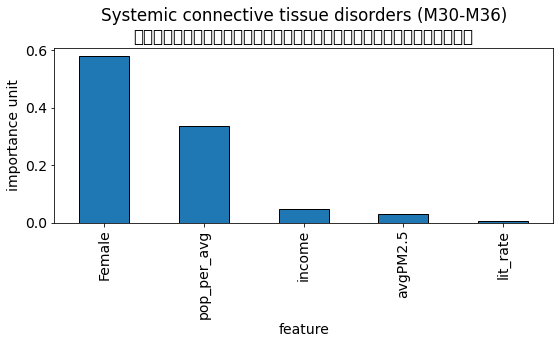

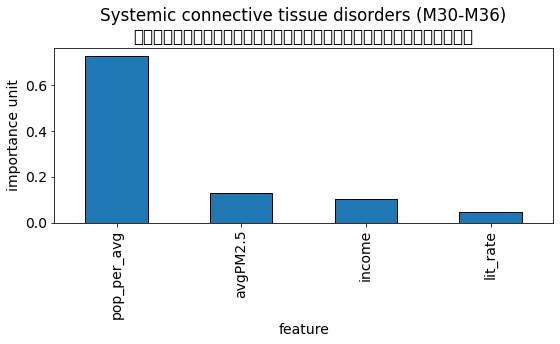

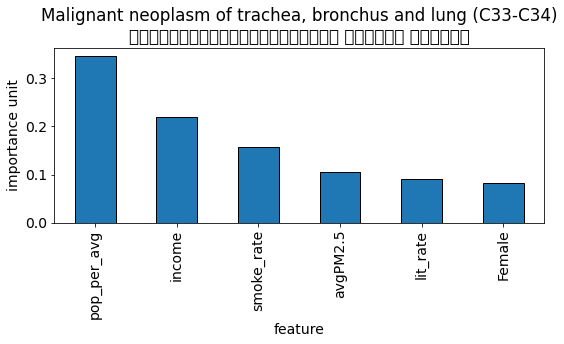

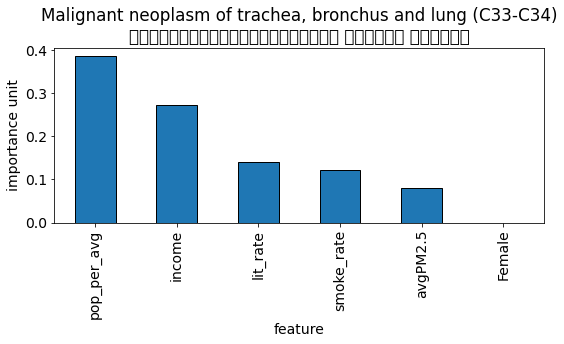

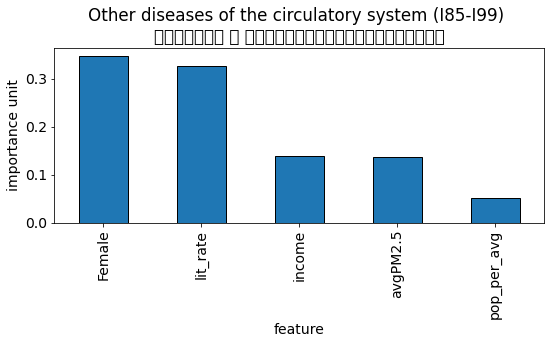

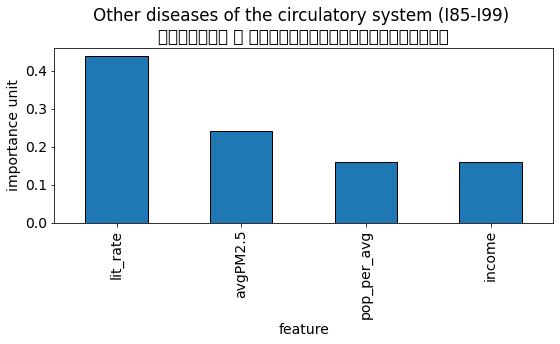

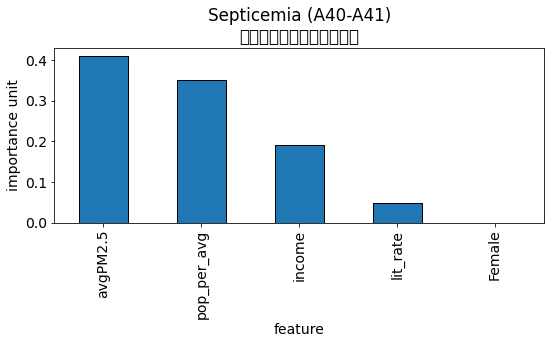

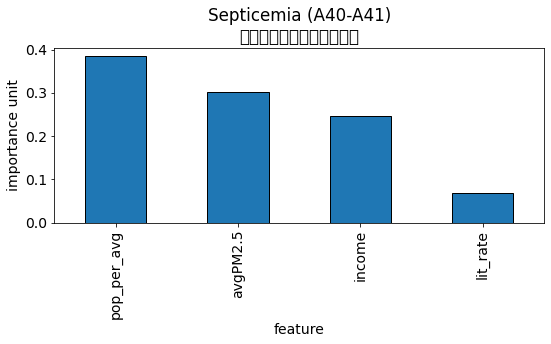

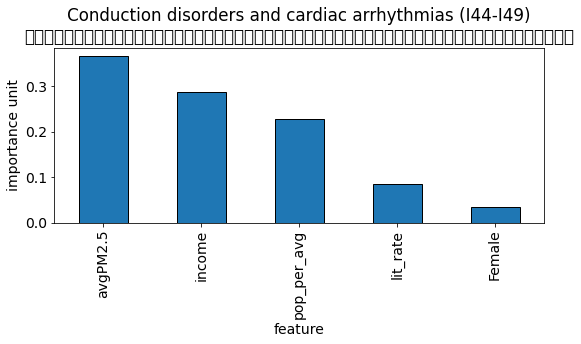

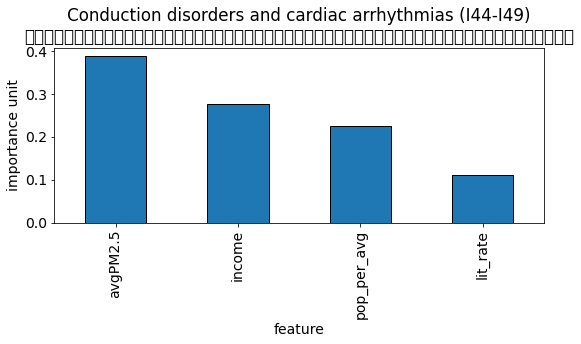

In [200]:
# work on many discease 
dis_list = ['Systemic connective tissue disorders (M30-M36)\nความผิดปกติของระบบเนื้อเยื่อประสาน',
       'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด',
       'Other diseases of the circulatory system (I85-I99) \nโรคอื่น ๆ ของระบบไหลเวียนโลหิต',
       'Septicemia (A40-A41)\nโลหิตเป็นพิษ',
       'Conduction disorders and cardiac arrhythmias (I44-I49)\nความผิดปกติของการนำกระแสไฟฟ้าหัวใจและหัวใจเต้นผิดจังหวะ']

file_list = ['tissue', 'lung', 'circular', 'blood_poision', 'heart']

for dis, file in zip(dis_list, file_list):
    in_pat_dis = in_pat[in_pat['disease'] == dis]
    in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
    in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
    data = build_data(in_pat_dis, avg_pm24_prov)

    
    # consider bangkok as central region 
    data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
    data['region'] = data['region'].astype('category')
    
    # split data
    prov_split = data[['province', 'region' ]].drop_duplicates()
    # split province into train-test provinces, stratify by regions
    prov_trn, prov_val = train_test_split(prov_split['province'].values, test_size=0.25, stratify=prov_split['region'].cat.codes.values )

    # encode gender columns
    data['gender'] = data['gender'].astype('category')
    data['Female'] = pd.get_dummies(data['gender'])['Female']
    
    print(f'----------{dis}-----------------')
    
    print(f'-------------------both gender-----------------------')
    
    if file == 'lung':
        x_cols = [ 'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
        
    else:
        x_cols = [ 'income',   'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
        
    y_col = 'rate' 
    data_proc = data

    x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
    y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values


    x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
    y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values
    
    model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

    cal_scores(y_val, model.predict(x_val), header_str='val_')
    
    importances = model.feature_importances_
    feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
    feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
    show_fea_imp(feat_imp, title=dis, filename=mdataset.report_folder + f'feat_imp_{file}_both.png')
    
    print(f'-------------------female-----------------------')
        
    if file == 'lung':
        x_cols = [ 'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
        
    else:
        x_cols = [ 'income',   'lit_rate', 'pop_per_avg', 'avgPM2.5']
        
    y_col = 'rate' 
    
    data_proc = data[data['gender'] == 'Female']

    x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
    y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values

    x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
    y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values
    
        
    model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

    cal_scores(y_val, model.predict(x_val), header_str='val_')
    
    importances = model.feature_importances_
    feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
    feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
    show_fea_imp(feat_imp, title=dis, filename=mdataset.report_folder + f'feat_imp_{file}_female.png')

data shape (664, 26)
----------Haemolytic disease of fetus and newborn (P55)
โรคเม็ดเลือดแตกของทารกในครรภ์และแรกเกิด-----------------
-------------------female-----------------------
best rf score  -0.13503893181415805
data shape (664, 26)
----------Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)
ภาวะอื่น ๆ ในระยะปริกำเนิด-----------------
-------------------female-----------------------
best rf score  0.13836743029611576
data shape (664, 26)
----------Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)
ความผิดปกติแต่กำเนิดอื่น ๆ-----------------
-------------------female-----------------------
best rf score  -0.11469083457941047
data shape (625, 26)
----------Other pregnancies with abortive outcome (O00-O02, O05-O08)
การตั้งครรภ์อื่น ๆ ที่สิ้นสุดโดยการแท้ง-----------------
-------------------female-----------------------
best rf score  0.011169880019139175
data shape (664, 26)
----------Other infections specIfic to the perinatal period (P38-P39

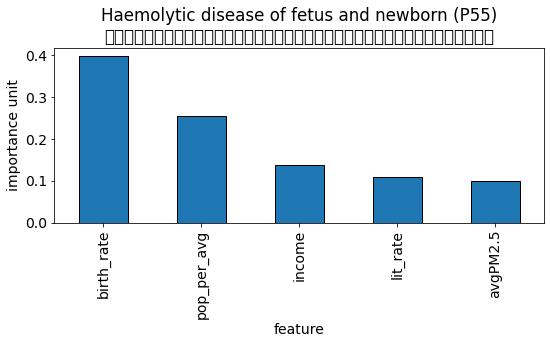

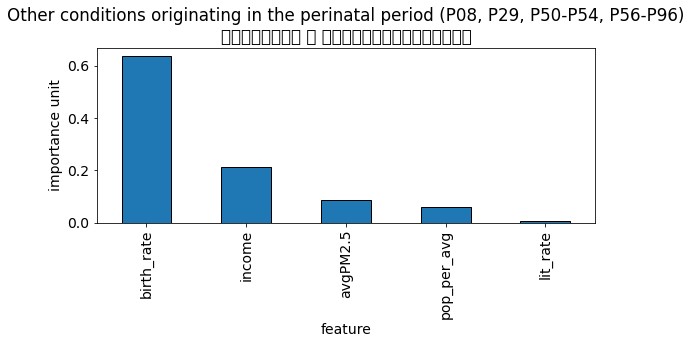

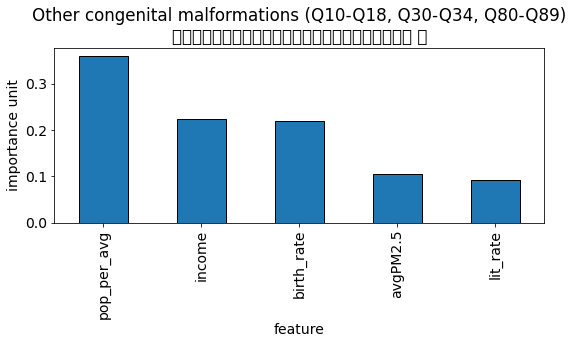

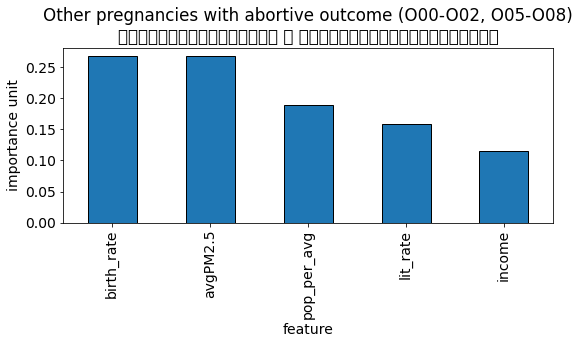

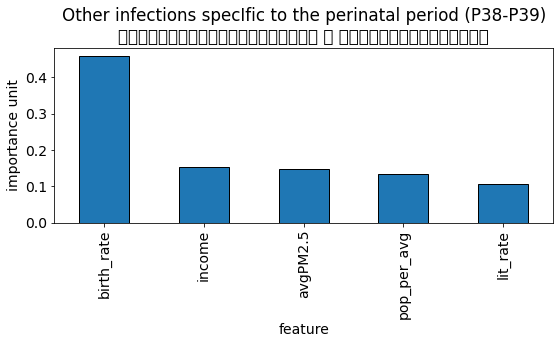

In [202]:
dis_list = ['Haemolytic disease of fetus and newborn (P55)\nโรคเม็ดเลือดแตกของทารกในครรภ์และแรกเกิด',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)\nความผิดปกติแต่กำเนิดอื่น ๆ',
 'Other pregnancies with abortive outcome (O00-O02, O05-O08)\nการตั้งครรภ์อื่น ๆ ที่สิ้นสุดโดยการแท้ง',
 'Other infections specIfic to the perinatal period (P38-P39)\nการติดเชื้อเฉพาะอื่น ๆ ในระยะปริกำเนิด']


file_list = ['defect1', 'defect2', 'defect3', 'defect4', 'defect5']

for dis, file in zip(dis_list, file_list):
    in_pat_dis = in_pat[in_pat['disease'] == dis]
    in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
    in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
    data = build_data(in_pat_dis, avg_pm24_prov)

    
    # consider bangkok as central region 
    data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
    data['region'] = data['region'].astype('category')
    
    # split data
    prov_split = data[['province', 'region' ]].drop_duplicates()
    # split province into train-test provinces, stratify by regions
    prov_trn, prov_val = train_test_split(prov_split['province'].values, test_size=0.25, stratify=prov_split['region'].cat.codes.values )

    # encode gender columns
    data['gender'] = data['gender'].astype('category')
    data['Female'] = pd.get_dummies(data['gender'])['Female']
    
    print(f'----------{dis}-----------------')
    
    print(f'-------------------female-----------------------')
        
    if file == 'lung':
        x_cols = [ 'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
        
    else:
        x_cols = [ 'income',   'lit_rate', 'pop_per_avg', 'avgPM2.5', 'birth_rate']
        
    y_col = 'rate' 
    
    data_proc = data[data['gender'] == 'Female']

    x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
    y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values

    x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
    y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values
    
        
    model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

    cal_scores(y_val, model.predict(x_val), header_str='val_')
    
    importances = model.feature_importances_
    feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
    feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
    show_fea_imp(feat_imp, title=dis, filename=mdataset.report_folder + f'feat_imp_{file}_female.png')

## Model OLS

In [400]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
in_pat = pd.read_csv(mdataset.health_folder + 'process/in_patient_2007_2019.csv').dropna()
in_pat['year'] = in_pat['year'].astype(int)
# in_pat = in_pat[~in_pat['year'].isin([2013, 2016])]
# add population 
in_pat = in_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate
birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

in_pat = in_pat.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
in_pat = in_pat.merge(provinces, on='province', how='left')

# remove use number and remove total in gender 
in_pat = in_pat[(in_pat['number_type'] == 'number') & (in_pat['gender'].isin(['Male', 'Female'])) ]
in_pat = in_pat[~in_pat['region'].isna()]

In [431]:
dis_list = ['Systemic connective tissue disorders (M30-M36)\nความผิดปกติของระบบเนื้อเยื่อประสาน',
       'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด',
       'Other diseases of the circulatory system (I85-I99) \nโรคอื่น ๆ ของระบบไหลเวียนโลหิต',
       'Septicemia (A40-A41)\nโลหิตเป็นพิษ',
       'Conduction disorders and cardiac arrhythmias (I44-I49)\nความผิดปกติของการนำกระแสไฟฟ้าหัวใจและหัวใจเต้นผิดจังหวะ'] + ['Haemolytic disease of fetus and newborn (P55)\nโรคเม็ดเลือดแตกของทารกในครรภ์และแรกเกิด',
 'Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)\nภาวะอื่น ๆ ในระยะปริกำเนิด',
 'Other congenital malformations (Q10-Q18, Q30-Q34, Q80-Q89)\nความผิดปกติแต่กำเนิดอื่น ๆ',
 'Other pregnancies with abortive outcome (O00-O02, O05-O08)\nการตั้งครรภ์อื่น ๆ ที่สิ้นสุดโดยการแท้ง',
 'Other infections specIfic to the perinatal period (P38-P39)\nการติดเชื้อเฉพาะอื่น ๆ ในระยะปริกำเนิด']

In [504]:
dis = 'Malignant neoplasm of trachea, bronchus and lung (C33-C34)\nเนื้องอกร้ายที่หลอดคอ หลอดลม และปอด'
dis = dis_list[6]
print(dis)
in_pat_dis = in_pat[in_pat['disease'] == dis]
in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
data_noyear = build_data(in_pat_dis, avg_pm24_prov_noyear)

# remove bkk
data_noyear = data_noyear[data_noyear['province'] != 'Bangkok']

Other conditions originating in the perinatal period (P08, P29, P50-P54, P56-P96)
ภาวะอื่น ๆ ในระยะปริกำเนิด
data shape (1350, 26)


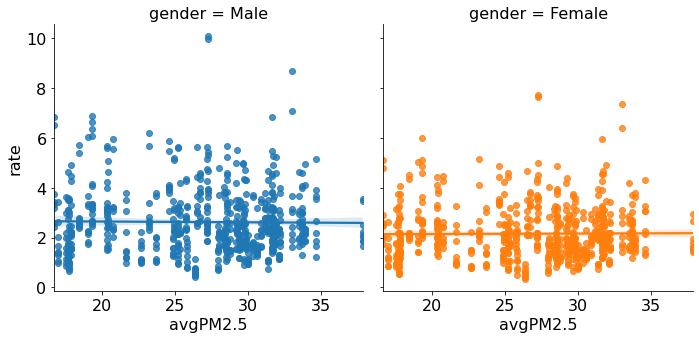

In [506]:
g = sns.lmplot(data=data_noyear, x='avgPM2.5', y='rate', hue='gender', col="gender" )

In [507]:
# preparing x and y

x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear[data_noyear['gender']=='Female']
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.839
Method:                 Least Squares   F-statistic:                              695.9
Date:                Sun, 18 Apr 2021   Prob (F-statistic):                   1.51e-260
Time:                        16:08:37   Log-Likelihood:                         -918.31
No. Observations:                 666   AIC:                                      1847.
Df Residuals:                     661   BIC:                                      1869.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income         -0.3714      0.136     -2.736      0.006      -0.638      -0.105
pop_per_avg     0.0369      0.191      0.194      0.846      -0.337       0.411
20-29          -0.0415      0.028     -1.486      0.138      -0.096       0.013
birth_rate      0.0858      0.008     10.553      0.000       0.070       0.102
avgPM2.5        0.0482      0.008      6.411      0.000       0.033       0.063
==============================================================================
Omnibus:                      174.981   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              453.738
Skew:                           1.330   Prob(JB):                     2.97e-99
Kurtosis:                       6.046   Cond. No.                         183.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [508]:
# preparing x and y

#x_cols = [ 'income', 'pop_per_avg',   '80-89', 'avgPM2.5' ]
x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear[data_noyear['gender']=='Male']
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                              669.7
Date:                Sun, 18 Apr 2021   Prob (F-statistic):                   6.13e-256
Time:                        16:08:38   Log-Likelihood:                         -1061.6
No. Observations:                 666   AIC:                                      2133.
Df Residuals:                     661   BIC:                                      2156.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income         -0.4313      0.171     -2.528      0.012      -0.766      -0.096
pop_per_avg     0.0581      0.235      0.247      0.805      -0.403       0.520
20-29          -0.0389      0.030     -1.287      0.199      -0.098       0.020
birth_rate      0.0999      0.009     10.856      0.000       0.082       0.118
avgPM2.5        0.0551      0.009      6.048      0.000       0.037       0.073
==============================================================================
Omnibus:                      195.344   Durbin-Watson:                   1.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              587.677
Skew:                           1.420   Prob(JB):                    2.44e-128
Kurtosis:                       6.620   Cond. No.                         185.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Cause Of dead

In [304]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)

dead = pd.read_csv(mdataset.health_folder + 'process/cause_of_dead.csv').dropna()
# add population 
dead = dead.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate

birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

dead = dead.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region', 'Greater Bangkok', 'Southern Region']

# add region
dead = dead.merge(provinces, on='province', how='left')

In [322]:
dis = 'โรคของระบบสืบพันธุ์และทางเดินปัสสาวะอื่น ๆ'
in_pat_dis = dead[dead['cause_of_dead'] == dis]
in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()

data = build_data(in_pat_dis, avg_pm24_prov)
data_noyear = build_data(in_pat_dis, avg_pm24_prov_noyear)


# consider bangkok as central region 
data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
data['region'] = data['region'].astype('category')

data = data[data['province'] != 'Bangkok']
data_noyear = data_noyear[data_noyear['province'] != 'Bangkok']

data shape (846, 26)
data shape (1350, 26)


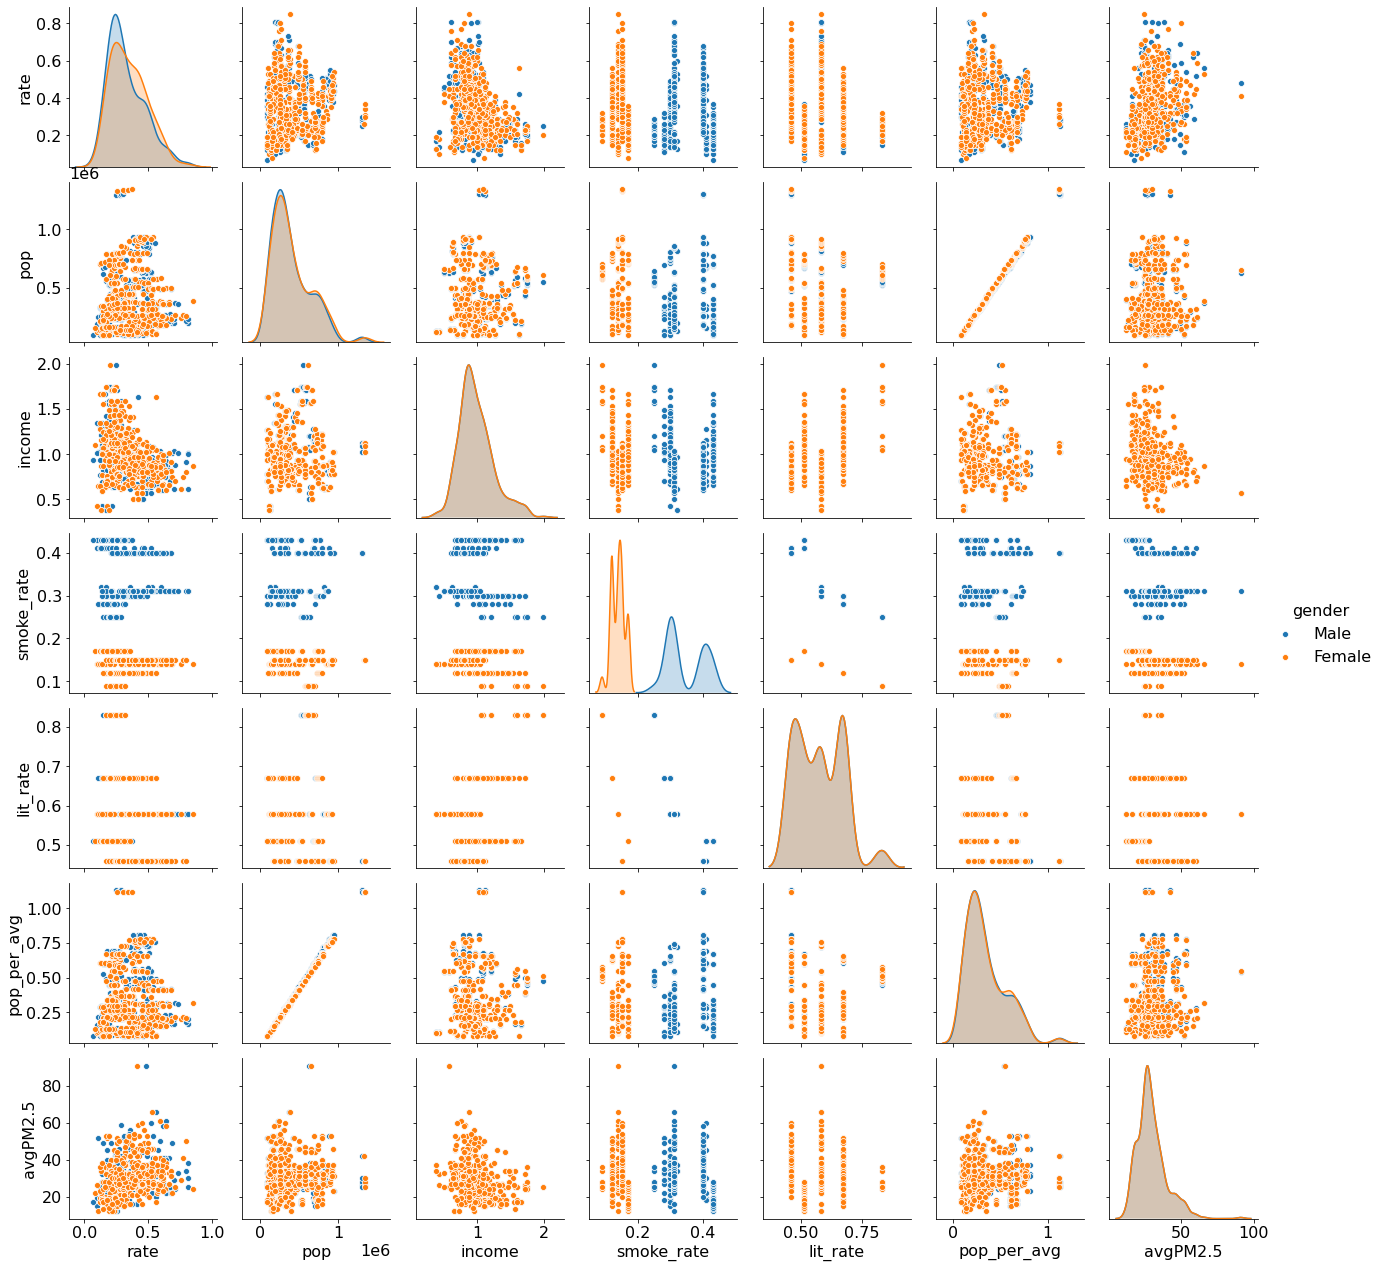

In [323]:
g = sns.pairplot(data, vars=['rate','pop','income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5'],
                 hue='gender' )

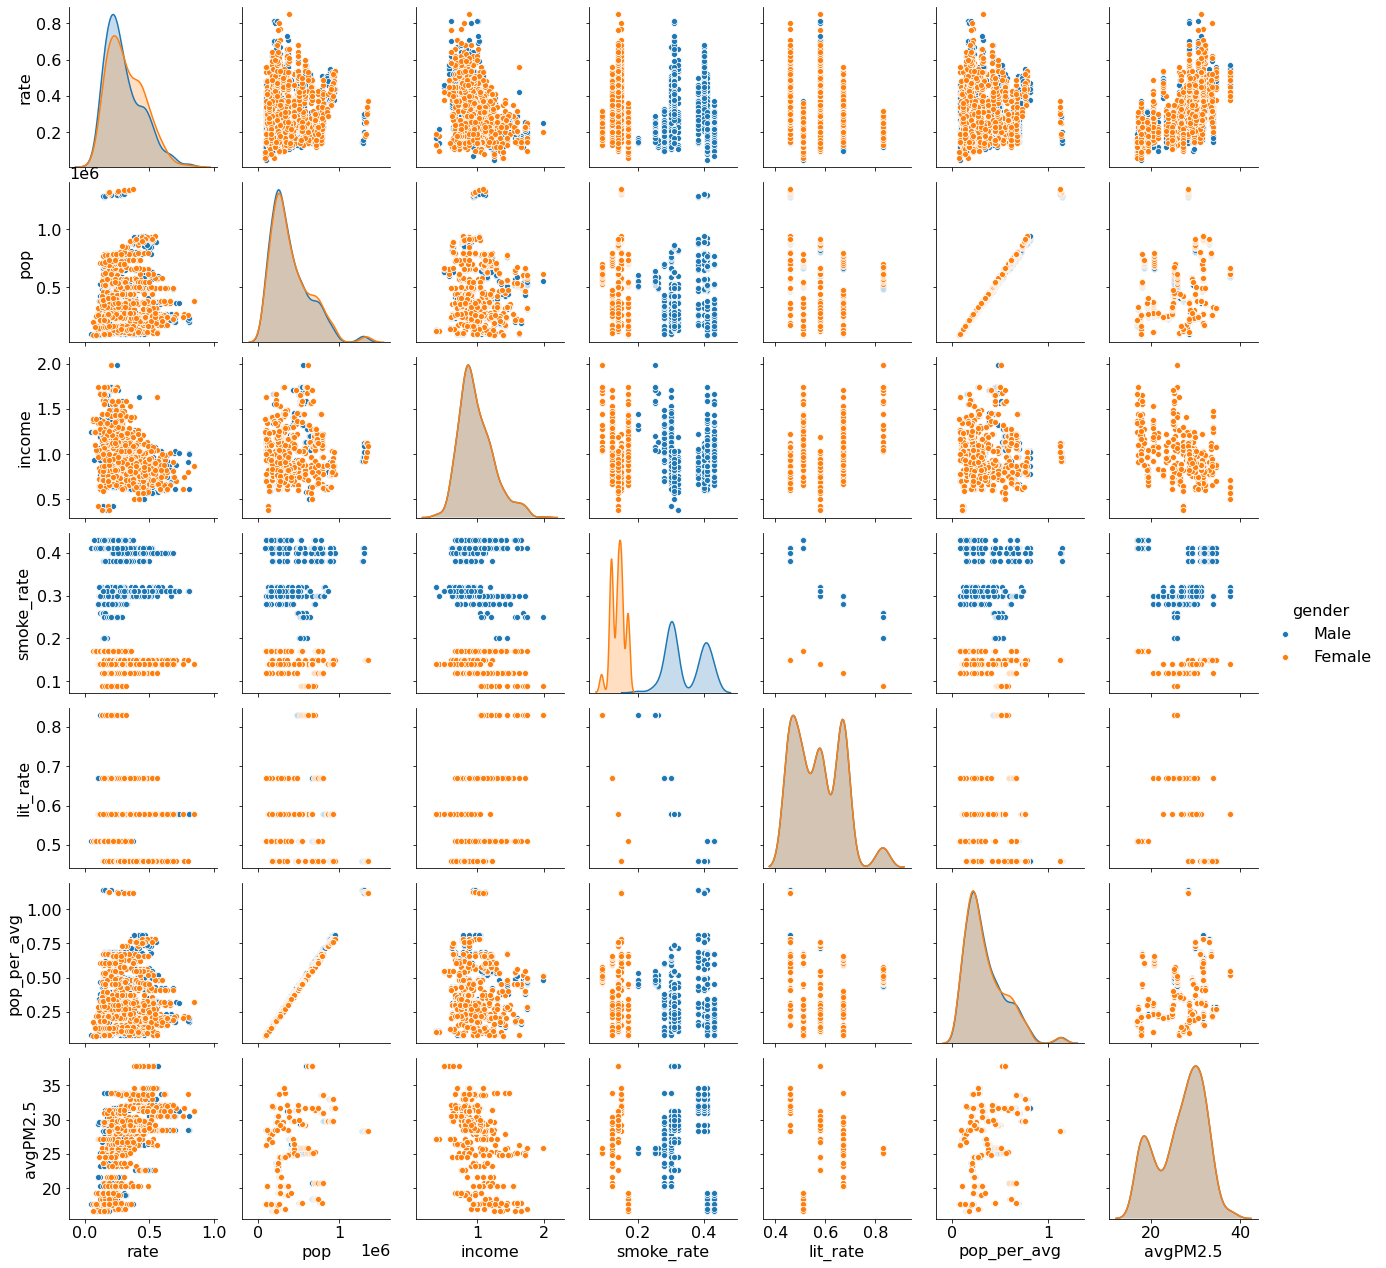

In [324]:
g = sns.pairplot(data_noyear, vars=['rate','pop','income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5'],
                 hue='gender' )

In [319]:
data.sort_values('avgPM2.5', ascending=False)

gender    province  year       pop  birth_number           region  rate  \
337    Male  Chiang Rai  2015  625193.0         10245  Northern Region  0.48   
353  Female  Chiang Rai  2015  652757.0         10245  Northern Region  0.41   
332    Male     Lampang  2015  369033.0          4466  Northern Region  0.56   
348  Female     Lampang  2015  383323.0          4466  Northern Region  0.53   
336    Male      Phayao  2015  235792.0          3358  Northern Region  0.64   
..      ...         ...   ...       ...           ...              ...   ...   
593  Female  Narathiwat  2017  402402.0         12415  Southern Region  0.19   
589  Female       Satun  2017  160868.0          4035  Southern Region  0.23   
615  Female       Satun  2018  161808.0          3836  Southern Region  0.22   
580    Male  Narathiwat  2017  393837.0         12415  Southern Region  0.24   
576    Male       Satun  2017  158832.0          4035  Southern Region  0.26   

     birth_rate  avgPM2.5  income  ...  40-49  50-59  60-69  70-79  80-89  \
337        16.0      91.0    0.57  ...  12.95  13.72   7.96   3.37   1.42   
353        16.0      91.0    0.57  ...  13.64  14.72   8.24   3.65   1.76   
332        12.0      66.0    0.87  ...  13.76  15.26   9.01   4.21   1.88   
348        12.0      66.0    0.87  ...  14.29  15.79   9.36   4.72   2.52   
336        14.0      61.0    0.75  ...  13.45  14.64   8.61   3.62   1.45   
..          ...       ...     ...  ...    ...    ...    ...    ...    ...   
593        31.0      12.0    0.72  ...  11.59   9.44   5.69   3.05   1.67   
589        25.0      12.0    0.95  ...  12.79   9.98   6.00   3.10   1.65   
615        24.0      12.0    0.95  ...  12.78  10.32   6.23   3.13   1.73   
580        32.0      12.0    0.72  ...  10.95   8.55   5.07   2.49   1.13   
576        25.0      12.0    0.95  ...  12.31   9.42   5.42   2.68   1.14   

      90+  pop_per_avg  pop_per_sum  smoke_rate  lit_rate  
337  0.19         0.54         0.66        0.31      0.58  
353  0.24         0.55         0.67        0.14      0.58  
332  0.23         0.32         0.39        0.31      0.58  
348  0.34         0.32         0.39        0.14      0.58  
336  0.14         0.21         0.25        0.31      0.58  
..    ...          ...          ...         ...       ...  
593  0.45         0.34         0.41        0.17      0.51  
589  0.28         0.13         0.16        0.17      0.51  
615  0.30         0.13         0.16        0.17      0.51  
580  0.36         0.34         0.42        0.43      0.51  
576  0.17         0.14         0.17        0.43      0.51  

[828 rows x 26 columns]

## Model

data shape (664, 26)
----------โรคมะเร็งหลอดลมและปอด-----------------
-------------------both gender-----------------------
best rf score  0.2902435501035164
-------------------female-----------------------
best rf score  -1.729901488981722
data shape (664, 26)
----------โรคของระบบสืบพันธุ์และทางเดินปัสสาวะอื่น ๆ-----------------
-------------------both gender-----------------------
best rf score  -0.487080141121736
-------------------female-----------------------
best rf score  -0.1648940662857755
data shape (664, 26)
----------โลหิตเป็นพิษ-----------------
-------------------both gender-----------------------
best rf score  -0.18985276682163135
-------------------female-----------------------
best rf score  -0.583285841993725


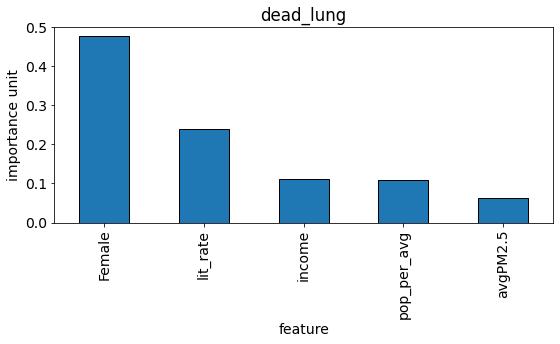

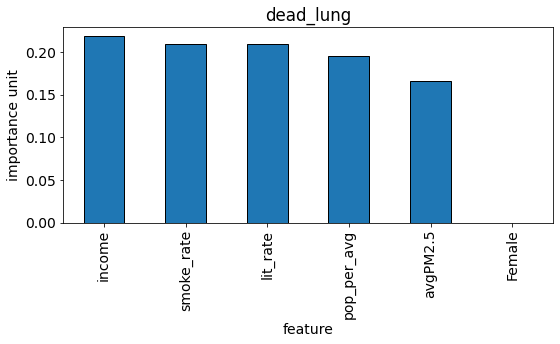

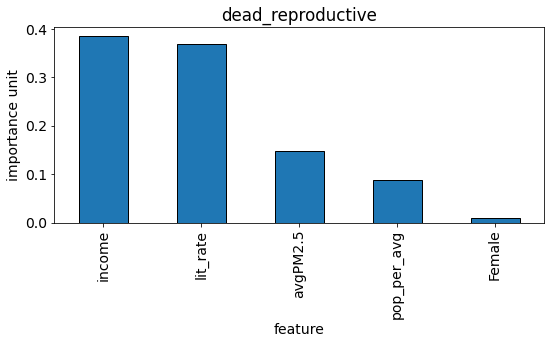

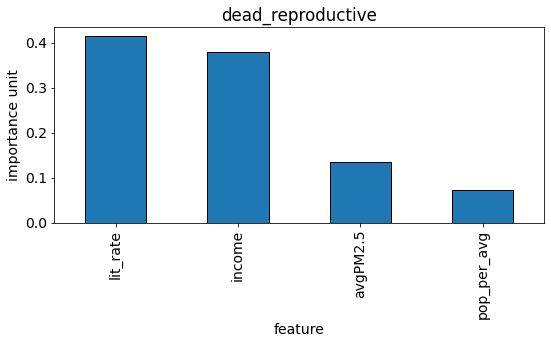

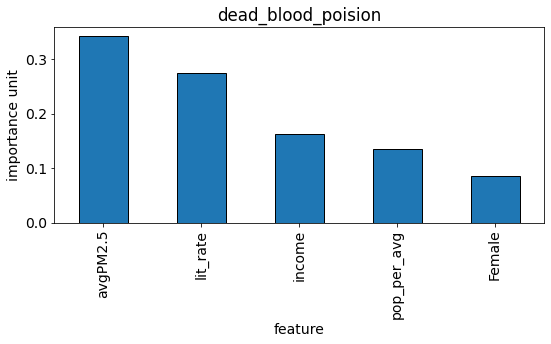

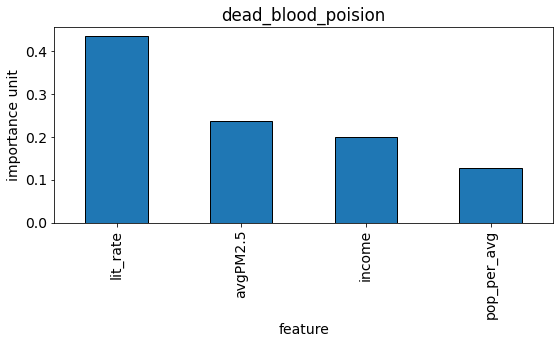

In [209]:
# work on many discease 
dis_list = ['โรคมะเร็งหลอดลมและปอด',
       'โรคของระบบสืบพันธุ์และทางเดินปัสสาวะอื่น ๆ', 'โลหิตเป็นพิษ']

file_list = [  'dead_lung', 'dead_reproductive', 'dead_blood_poision' ]

for dis, file in zip(dis_list, file_list):
    in_pat_dis = dead[dead['cause_of_dead'] == dis]
    in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
    in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
    data = build_data(in_pat_dis, avg_pm24_prov)

    # consider bangkok as central region 
    data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
    data['region'] = data['region'].astype('category')
    
    # split data
    prov_split = data[['province', 'region' ]].drop_duplicates()
    # split province into train-test provinces, stratify by regions
    prov_trn, prov_val = train_test_split(prov_split['province'].values, test_size=0.25, stratify=prov_split['region'].cat.codes.values )

    # encode gender columns
    data['gender'] = data['gender'].astype('category')
    data['Female'] = pd.get_dummies(data['gender'])['Female']
    
    print(f'----------{dis}-----------------')
    
    print(f'-------------------both gender-----------------------')
    
    if file == 'lung':
        x_cols = [ 'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
        
    else:
        x_cols = [ 'income',   'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
        
    y_col = 'rate' 
    data_proc = data

    x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
    y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values


    x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
    y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values
    
    model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

    cal_scores(y_val, model.predict(x_val), header_str='val_')
    
    importances = model.feature_importances_
    feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
    feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
    show_fea_imp(feat_imp, title=file, filename=mdataset.report_folder + f'feat_imp_{file}_both.png')
    
    print(f'-------------------female-----------------------')
        
    if (file == 'lung') or (file=='dead_lung'):
        x_cols = [ 'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5' ]
        
    else:
        x_cols = [ 'income',   'lit_rate', 'pop_per_avg', 'avgPM2.5']
        
    y_col = 'rate' 
    
    data_proc = data[data['gender'] == 'Female']

    x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
    y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values

    x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
    y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values
    
        
    model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

    cal_scores(y_val, model.predict(x_val), header_str='val_')
    
    importances = model.feature_importances_
    feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
    feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
    show_fea_imp(feat_imp, title=file, filename=mdataset.report_folder + f'feat_imp_{file}_female.png')

data shape (41, 26)
----------การตั้งครรภ์ การคลอดและระยะหลังคลอดอื่น ๆ-----------------
-------------------female-----------------------
best rf score  -0.037037037037037056
data shape (226, 26)
----------ความผิดปกติแต่กำเนิดของระบบไหลเวียนโลหิตอื่น ๆ-----------------
-------------------female-----------------------
best rf score  0.017282785034711295
data shape (88, 26)
----------โรคแทรกของการเจ็บครรภ์และการคลอด-----------------
-------------------female-----------------------
best rf score  -0.12291395929694089


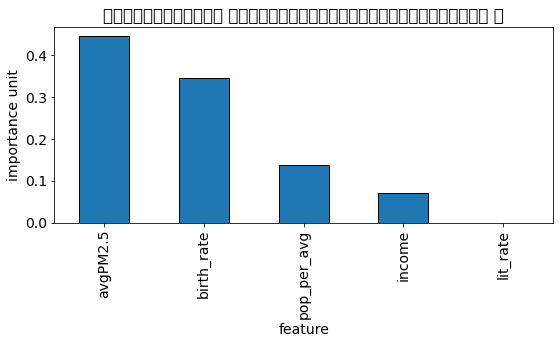

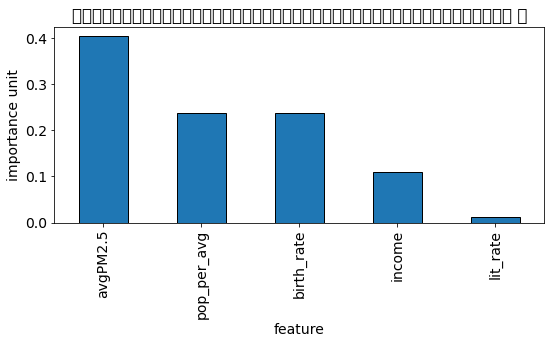

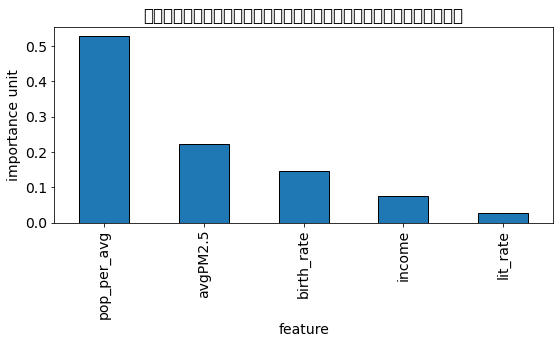

In [211]:
# work on many discease 
dis_list = ['การตั้งครรภ์ การคลอดและระยะหลังคลอดอื่น ๆ',
 'ความผิดปกติแต่กำเนิดของระบบไหลเวียนโลหิตอื่น ๆ',
 'โรคแทรกของการเจ็บครรภ์และการคลอด']

file_list = [  'dead_defect1', 'dead_defect2', 'dead_defect3' ]

for dis, file in zip(dis_list, file_list):
    in_pat_dis = dead[dead['cause_of_dead'] == dis]
    in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
    in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
    data = build_data(in_pat_dis, avg_pm24_prov)

    # consider bangkok as central region 
    data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
    data['region'] = data['region'].astype('category')
    
    # split data
    prov_split = data[['province', 'region' ]].drop_duplicates()
    # split province into train-test provinces, stratify by regions
    prov_trn, prov_val = train_test_split(prov_split['province'].values, test_size=0.25, stratify=prov_split['region'].cat.codes.values )

    # encode gender columns
    data['gender'] = data['gender'].astype('category')
    data['Female'] = pd.get_dummies(data['gender'])['Female']
    
    print(f'----------{dis}-----------------')
    
   
    print(f'-------------------female-----------------------')
        
    if file == 'lung':
        x_cols = [ 'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
        
    else:
        x_cols = [ 'income',  'birth_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5']
        
    y_col = 'rate' 
    
    data_proc = data[data['gender'] == 'Female']

    x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
    y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values

    x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
    y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values
    
        
    model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

    cal_scores(y_val, model.predict(x_val), header_str='val_')
    
    importances = model.feature_importances_
    feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
    
    feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
    show_fea_imp(feat_imp, title=dis, filename=mdataset.report_folder + f'feat_imp_{file}_female.png')

## Model OLS

In [510]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)

dead = pd.read_csv(mdataset.health_folder + 'process/cause_of_dead.csv').dropna()
# add population 
dead = dead.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate

birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)

dead = dead.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region', 'Greater Bangkok', 'Southern Region']

# add region
dead = dead.merge(provinces, on='province', how='left')

In [509]:
dis_list = ['โรคมะเร็งหลอดลมและปอด',
       'โรคของระบบสืบพันธุ์และทางเดินปัสสาวะอื่น ๆ', 'โลหิตเป็นพิษ'] + ['การตั้งครรภ์ การคลอดและระยะหลังคลอดอื่น ๆ',
 'ความผิดปกติแต่กำเนิดของระบบไหลเวียนโลหิตอื่น ๆ',
 'โรคแทรกของการเจ็บครรภ์และการคลอด']

In [538]:
dis = dis_list[-1]
print(dis)

in_pat_dis = dead[dead['cause_of_dead'] == dis]
in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()

data = build_data(in_pat_dis, avg_pm24_prov)
data_noyear = build_data(in_pat_dis, avg_pm24_prov_noyear)


# consider bangkok as central region 
data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
data['region'] = data['region'].astype('category')

data = data[data['province'] != 'Bangkok']
data_noyear = data_noyear[data_noyear['province'] != 'Bangkok']

โรคแทรกของการเจ็บครรภ์และการคลอด
data shape (113, 26)
data shape (183, 26)


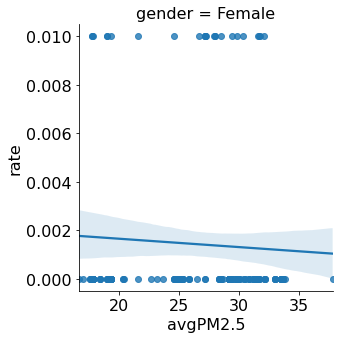

In [539]:
g = sns.lmplot(data=data_noyear, x='avgPM2.5', y='rate', hue='gender', col="gender" )

In [540]:
# preparing x and y
#x_cols = [ 'income', 'pop_per_avg',   '80-89', 'avgPM2.5' ]
x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear[data_noyear['gender']=='Female']
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.278
Model:                            OLS   Adj. R-squared (uncentered):              0.256
Method:                 Least Squares   F-statistic:                              13.14
Date:                Sun, 18 Apr 2021   Prob (F-statistic):                    7.88e-11
Time:                        16:52:28   Log-Likelihood:                          761.13
No. Observations:                 176   AIC:                                     -1512.
Df Residuals:                     171   BIC:                                     -1496.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income         -0.0011      0.001     -1.219      0.224      -0.003       0.001
pop_per_avg    -0.0054      0.001     -4.546      0.000      -0.008      -0.003
20-29           0.0007      0.000      3.000      0.003       0.000       0.001
birth_rate     -0.0001   7.16e-05     -1.890      0.060      -0.000    6.01e-06
avgPM2.5     -5.36e-05   5.89e-05     -0.910      0.364      -0.000    6.27e-05
==============================================================================
Omnibus:                       54.510   Durbin-Watson:                   2.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.143
Skew:                           1.627   Prob(JB):                     2.19e-21
Kurtosis:                       4.543   Cond. No.                         181.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [535]:
# preparing x and y

x_cols = [ 'income', 'pop_per_avg',   '80-89', 'avgPM2.5' ]
#x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear[data_noyear['gender']=='Male']
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

ValueError: zero-size array to reduction operation maximum which has no identity

# Out Patient

In [337]:
def build_data_no_gender(illness_data, poll_data):
    
    data = illness_data[['province', 'year', 'pop', 'birth_number', 'region', 'rate', 'birth_rate']].drop_duplicates()
    
    
    # merge with pollution 
    data = data.merge(poll_data.dropna(), on=['year', 'province'], how='inner')
    
    # merge with income
    income = load_income()
    data = data.merge(income.dropna(), on=['year', 'province'], how='inner')
    
    # merge with pop_ratio
    pop_ratio = load_pop_ratio()
    pop_ratio = pop_ratio[pop_ratio['gender'] == 'Total']
    data = data.merge(pop_ratio.dropna(), on=['year', 'province' ], how='inner')
    
    # merge with province pop size
    pop_avg = load_pop_avg()
    pop_avg = pop_avg[pop_avg['gender'] == 'Total']
    data = data.merge(pop_avg.dropna(), on=['year', 'province' ], how='inner')
    
    # merge with smoke_rate
    #smoke_rate = load_smoke()
    #data = data.merge(smoke_rate.dropna(), on=['year', 'region', 'gender'], how='inner')
    
    # merge with literacy rate
    lit_rate = load_lit_rate()
    data = data.merge(lit_rate.dropna(), on=['region'], how='inner')
    
    
    print('data shape', data.shape)
    return data.drop_duplicates()

In [371]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
out_pat = pd.read_csv(mdataset.health_folder + 'process/out_patient_2007_2019.csv').dropna()
out_pat['gender'] = 'Total'
# add population 
out_pat = out_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate

birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)


out_pat = out_pat.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
out_pat = out_pat.merge(provinces, on='province', how='left')

In [384]:
dis = 'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities'
in_pat_dis = out_pat[out_pat['disease'] == dis]
in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
data = build_data_no_gender(in_pat_dis, avg_pm24_prov)
data_noyear = build_data_no_gender(in_pat_dis, avg_pm24_prov_noyear)


# consider bangkok as central region 
data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
data['region'] = data['region'].astype('category')

data = data[data['province'] != 'Bangkok']
data_noyear = data_noyear[data_noyear['province'] != 'Bangkok']

#data = data[data['birth_rate'] >= 7.0]
#data_noyear = data_noyear[data_noyear['birth_rate'] >= 7.0]
data = data[data['rate'] > 0]
data_noyear = data_noyear[data_noyear['rate'] > 0]

data shape (254, 26)
data shape (732, 26)


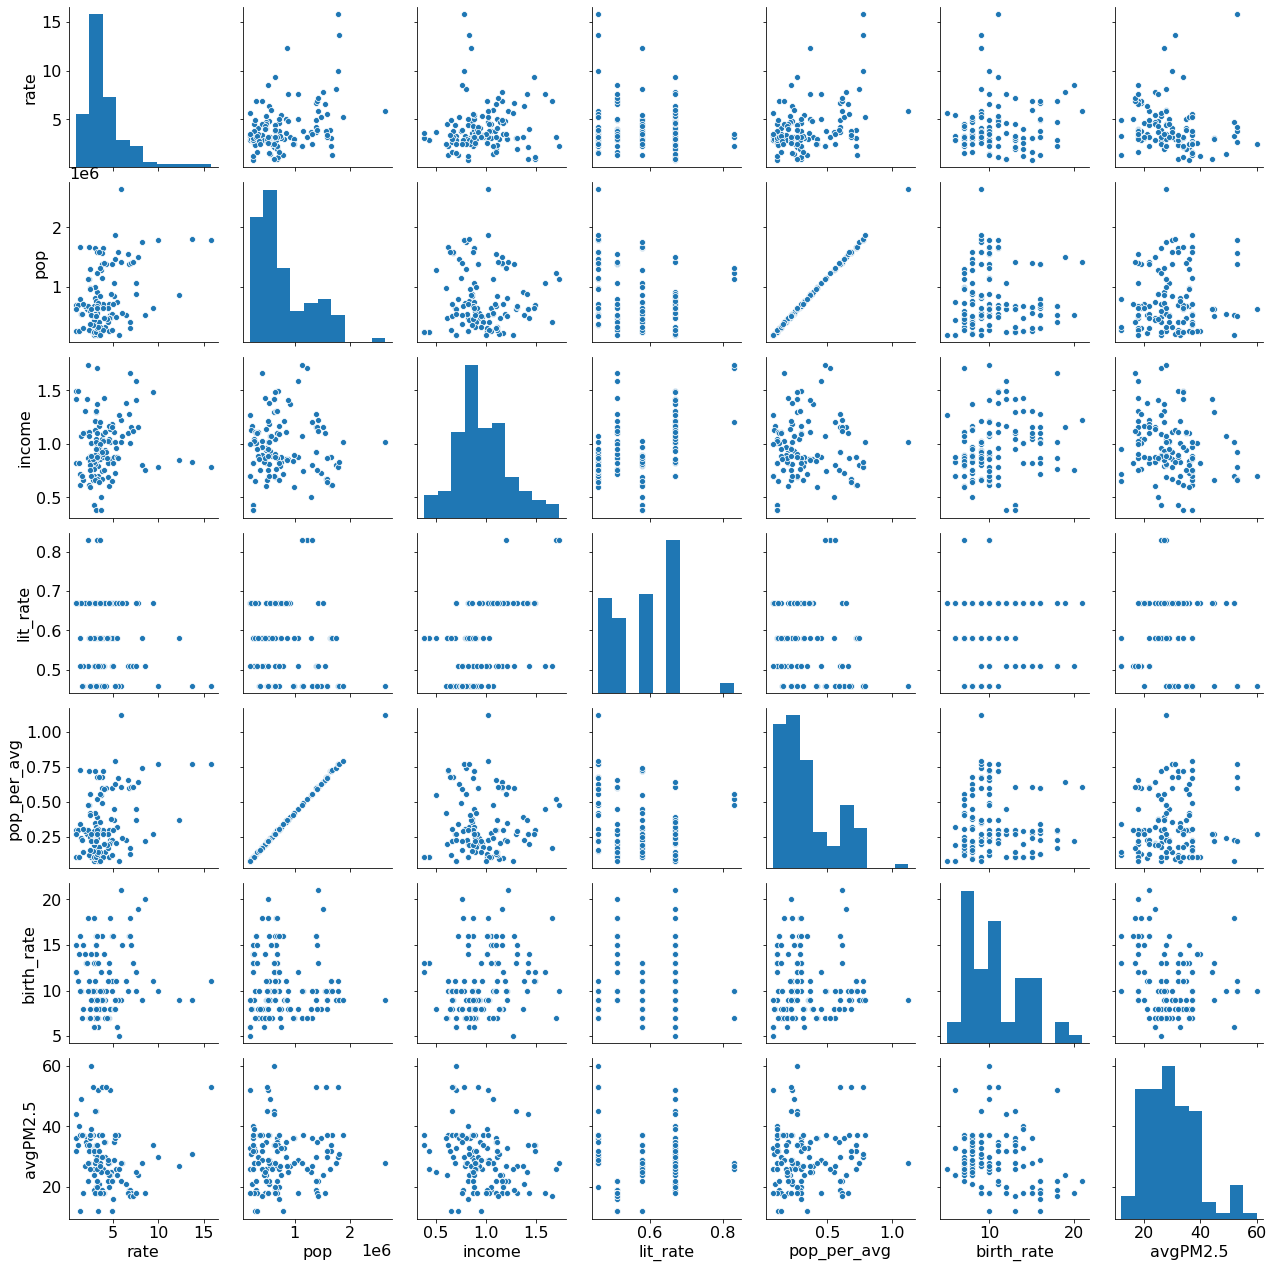

In [386]:
g = sns.pairplot(data, vars=['rate','pop','income', 'lit_rate', 'pop_per_avg', 'birth_rate', 'avgPM2.5'] )

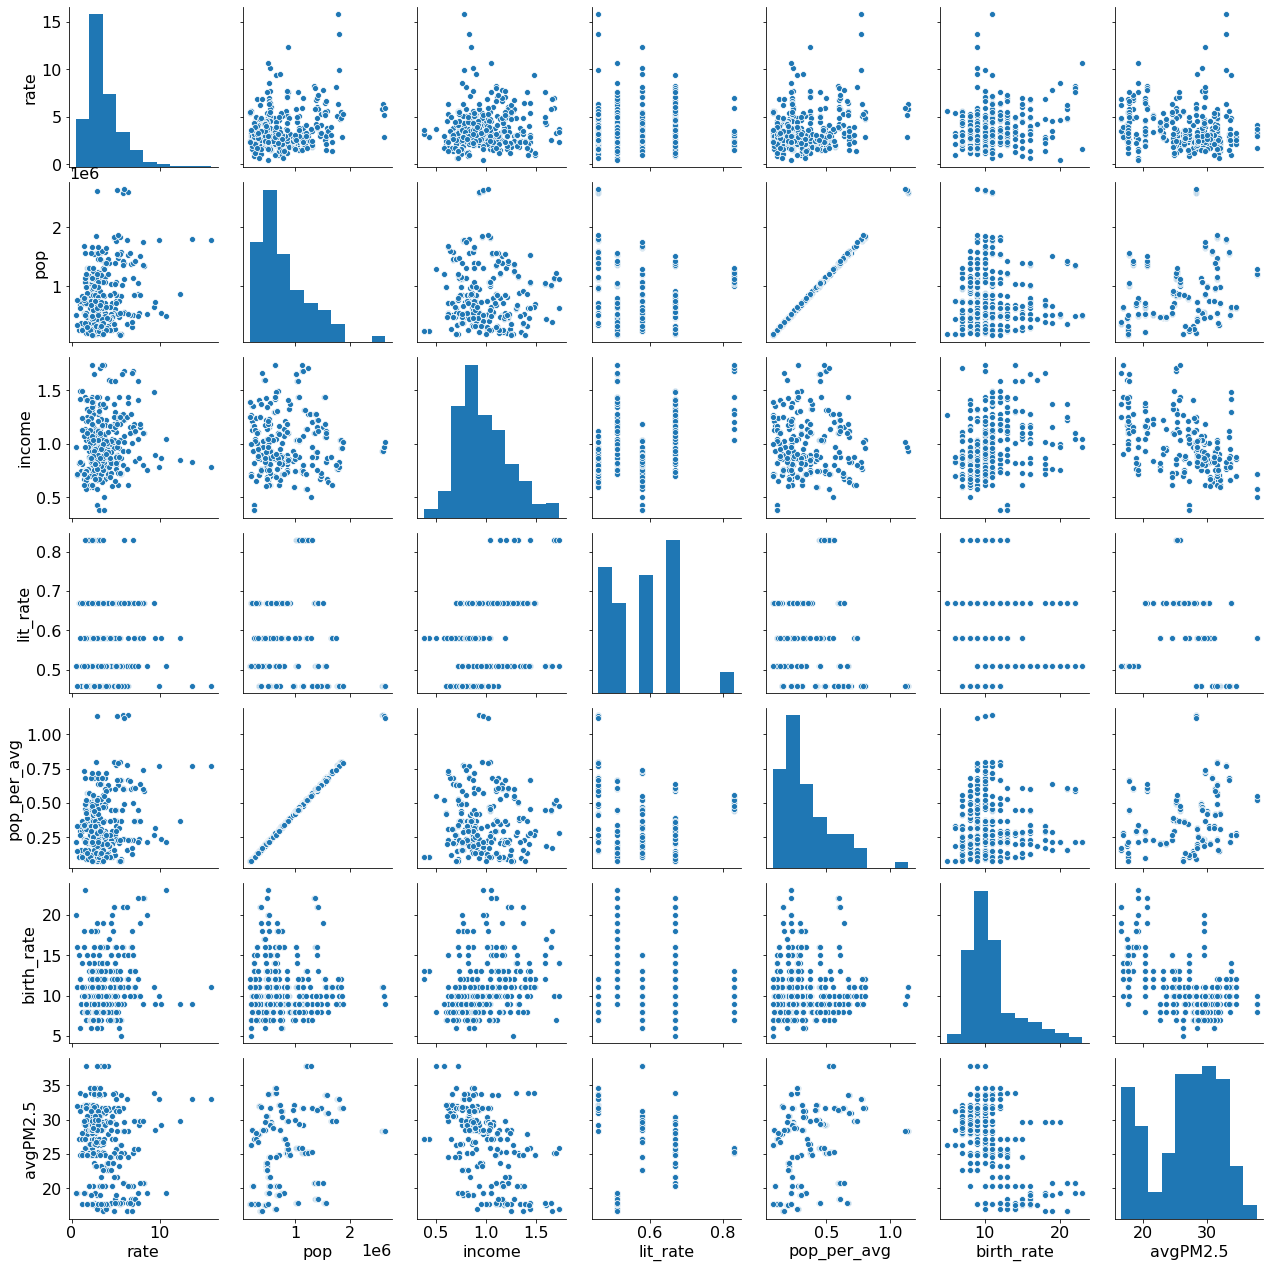

In [387]:
g = sns.pairplot(data_noyear, vars=['rate','pop','income', 'lit_rate', 'pop_per_avg', 'birth_rate', 'avgPM2.5'] )

## Model RF

data shape (192, 26)
----------ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period -----------------
-------------------both gender-----------------------
best rf score  -0.0031836176275737613
data shape (192, 26)
----------รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities-----------------
-------------------both gender-----------------------
best rf score  -0.02340481468450406


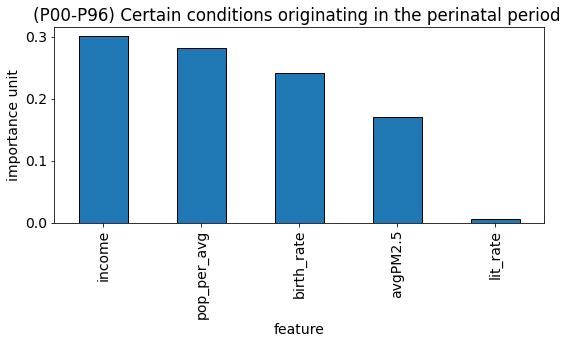

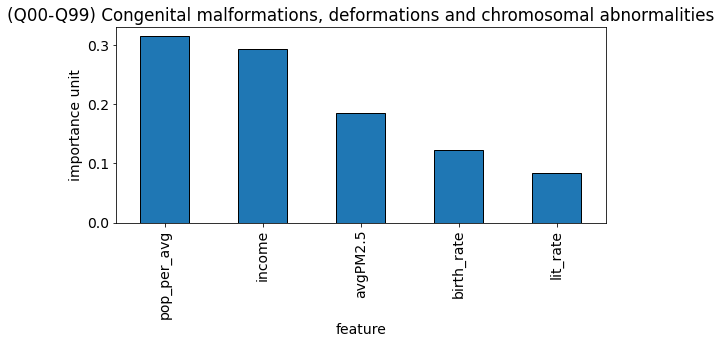

In [230]:
# work on many discease 
dis_list = ['ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period ',
 'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities']

title_list = ['(P00-P96) Certain conditions originating in the perinatal period ',
 '(Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities']

file_list = ['out_p00-p96', 'out_Q00-Q99']

for dis, file, title in zip(dis_list, file_list, title_list):
    in_pat_dis = out_pat[out_pat['disease'] == dis]
    in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
    in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
    data = build_data_no_gender(in_pat_dis, avg_pm24_prov)

    
    # consider bangkok as central region 
    data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
    data['region'] = data['region'].astype('category')
    
    # split data
    prov_split = data[['province', 'region' ]].drop_duplicates()
    # split province into train-test provinces, stratify by regions
    prov_trn, prov_val = train_test_split(prov_split['province'].values, test_size=0.25, stratify=prov_split['region'].cat.codes.values )

    
    
    print(f'----------{dis}-----------------')
    
    print(f'-------------------both gender-----------------------')
    
    if file == 'lung':
        x_cols = [ 'income',  'smoke_rate', 'lit_rate', 'pop_per_avg', 'avgPM2.5', 'Female']
        
    else:
        x_cols = [ 'income',   'lit_rate', 'pop_per_avg', 'avgPM2.5', 'birth_rate']
        
    y_col = 'rate' 
    data_proc = data

    x_trn = data_proc[data_proc['province'].isin(prov_trn)][x_cols].values
    y_trn = data_proc[data_proc['province'].isin(prov_trn)][y_col].values


    x_val = data_proc[data_proc['province'].isin(prov_val)][x_cols].values
    y_val = data_proc[data_proc['province'].isin(prov_val)][y_col].values
    
    model = do_rf_search(x_trn ,
        y_trn, sample_weight=[],
        cv_split  = '',
        n_splits= 3,
        x_tree=False,
        n_jobs=-2)

    cal_scores(y_val, model.predict(x_val), header_str='val_')
    
    importances = model.feature_importances_
    feat_imp = pd.DataFrame(
                importances,
                index=x_cols,
                columns=['importance'])
    feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index()
    show_fea_imp(feat_imp, title=title, filename=mdataset.report_folder + f'feat_imp_{file}_both.png')
    
     

## Model OLS

In [541]:
population = pd.read_csv(mdataset.health_folder  + 'process/pop_prov.csv')  
population = population.drop(['province_th', 'gender_th'], axis=1)

pop = population.melt(id_vars=['province', 'gender'], var_name='year', value_name='pop')
pop['year'] = pop['year'].astype(int)
out_pat = pd.read_csv(mdataset.health_folder + 'process/out_patient_2007_2019.csv').dropna()
out_pat['gender'] = 'Total'
# add population 
out_pat = out_pat.merge(pop, on=['province', 'gender', 'year'], how='left')

# add birth rate

birth_rate = pd.read_csv(mdataset.health_folder  + 'process/birth_prov.csv')
birth_rate = birth_rate.rename(columns={'number':'birth_number'})
birth_rate['year'] = birth_rate['year'].astype(int)


out_pat = out_pat.merge(birth_rate, on=['province',  'year'], how='left')

# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]

region_list = ['Northern Region', 'Northeastern Region', 'Central Region','Greater Bangkok','Southern Region']

# add region
out_pat = out_pat.merge(provinces, on='province', how='left')

In [542]:
dis_list = ['ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period ',
 'รูปร่างผิดปกติแต่กำเนิด  การพิการจนผิดรูปแต่กำเนิดและโครโมโซม  ผิดปกติ (Q00-Q99) Congenital malformations, deformations and chromosomal abnormalities']


In [551]:
dis = dis_list[0]
print(dis)
in_pat_dis = out_pat[out_pat['disease'] == dis]
in_pat_dis['rate'] = (in_pat_dis['number']/in_pat_dis['pop']*1000).round(2)
in_pat_dis['birth_rate'] = (in_pat_dis['birth_number']/in_pat_dis['pop']*1000).round()
    
data = build_data_no_gender(in_pat_dis, avg_pm24_prov)
data_noyear = build_data_no_gender(in_pat_dis, avg_pm24_prov_noyear)


# consider bangkok as central region 
data['region'] = data['region'].str.replace('Greater Bangkok', 'Central Region' )
data['region'] = data['region'].astype('category')

data = data[data['province'] != 'Bangkok']
data_noyear = data_noyear[data_noyear['province'] != 'Bangkok']

ภาวะผิดปกติของทารกที่เกิดขึ้นในระยะปริกำเนิด (อายุครรภ์ 22 สัปดาห์ขึ้นไปจนถึง 7 วันหลังคลอด) (P00-P96) Certain conditions originating in the perinatal period 
data shape (254, 26)
data shape (732, 26)


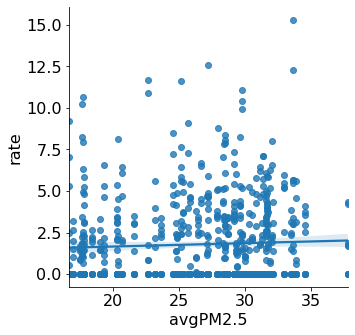

In [552]:
g = sns.lmplot(data=data_noyear, x='avgPM2.5', y='rate' )

In [553]:
# preparing x and y
#x_cols = [ 'income', 'pop_per_avg',   '80-89', 'avgPM2.5' ]
x_cols = [ 'income', 'pop_per_avg',   '20-29', 'birth_rate', 'avgPM2.5' ]
y_cols = 'rate'

df = data_noyear 
x = df[x_cols] 
y = df[y_cols].values

mod = sm.OLS(y, x)    # Describe model
res = mod.fit()       # Fit model
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.349
Model:                            OLS   Adj. R-squared (uncentered):              0.344
Method:                 Least Squares   F-statistic:                              77.93
Date:                Sun, 18 Apr 2021   Prob (F-statistic):                    1.92e-65
Time:                        16:55:05   Log-Likelihood:                         -1695.0
No. Observations:                 732   AIC:                                      3400.
Df Residuals:                     727   BIC:                                      3423.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
income          0.0128      0.336      0.038      0.969      -0.646       0.672
pop_per_avg     0.1591      0.461      0.345      0.730      -0.745       1.063
20-29           0.0252      0.065      0.386      0.700      -0.103       0.153
birth_rate      0.0335      0.038      0.891      0.373      -0.040       0.107
avgPM2.5        0.0386      0.018      2.112      0.035       0.003       0.075
==============================================================================
Omnibus:                      239.468   Durbin-Watson:                   3.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              651.901
Skew:                           1.664   Prob(JB):                    2.76e-142
Kurtosis:                       6.210   Cond. No.                         161.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""